# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

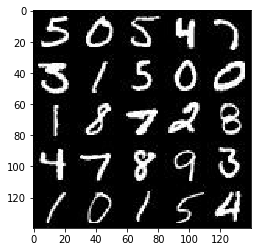

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

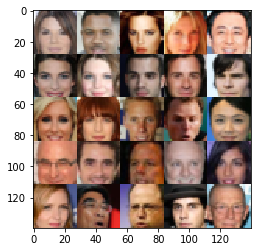

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name = 'real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name = 'fake')
    lr = tf.placeholder(tf.float32,name = 'learning_rate')

    return (input_real, input_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse = reuse):
        alpha = 0.02
        
        x1 = tf.layers.conv2d(images,64,5,strides = 2,padding = 'same')
        relu1 = tf.maximum(alpha * x1,x1)
        
        x2 = tf.layers.conv2d(relu1,128,5,strides = 2,padding = 'same')
        bn2 = tf.layers.batch_normalization(x2,training = True)
        relu2 = tf.maximum(alpha * bn2,bn2)
        
        x3 = tf.layers.conv2d(relu2,256,5,strides = 2,padding = 'same')
        bn3 = tf.layers.batch_normalization(x3,training = True)
        relu3 = tf.maximum(alpha * bn3,bn3)
        
        flat = tf.reshape(relu3,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return (out,logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.02
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out
    
    
    
      


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.1433... Generator Loss: 4.0648
Epoch 1/2... Batch 20... Discriminator Loss: 0.1277... Generator Loss: 7.2319
Epoch 1/2... Batch 30... Discriminator Loss: 3.4697... Generator Loss: 0.1176
Epoch 1/2... Batch 40... Discriminator Loss: 0.2212... Generator Loss: 2.4641
Epoch 1/2... Batch 50... Discriminator Loss: 1.2169... Generator Loss: 1.0714
Epoch 1/2... Batch 60... Discriminator Loss: 0.6673... Generator Loss: 1.1544
Epoch 1/2... Batch 70... Discriminator Loss: 1.7493... Generator Loss: 4.3069
Epoch 1/2... Batch 80... Discriminator Loss: 0.3945... Generator Loss: 1.5910
Epoch 1/2... Batch 90... Discriminator Loss: 2.3720... Generator Loss: 0.1068
Epoch 1/2... Batch 100... Discriminator Loss: 1.3815... Generator Loss: 5.0632


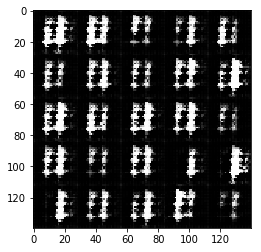

Epoch 1/2... Batch 110... Discriminator Loss: 1.4745... Generator Loss: 0.3199
Epoch 1/2... Batch 120... Discriminator Loss: 3.8903... Generator Loss: 9.8832
Epoch 1/2... Batch 130... Discriminator Loss: 0.4781... Generator Loss: 1.9338
Epoch 1/2... Batch 140... Discriminator Loss: 0.0615... Generator Loss: 6.0650
Epoch 1/2... Batch 150... Discriminator Loss: 0.2941... Generator Loss: 1.7727
Epoch 1/2... Batch 160... Discriminator Loss: 0.7073... Generator Loss: 5.7549
Epoch 1/2... Batch 170... Discriminator Loss: 1.2639... Generator Loss: 0.6639
Epoch 1/2... Batch 180... Discriminator Loss: 0.9358... Generator Loss: 0.7973
Epoch 1/2... Batch 190... Discriminator Loss: 0.3228... Generator Loss: 2.1874
Epoch 1/2... Batch 200... Discriminator Loss: 1.8307... Generator Loss: 0.2332


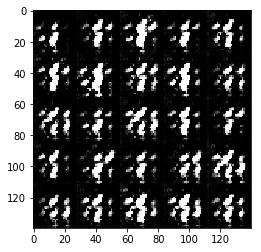

Epoch 1/2... Batch 210... Discriminator Loss: 0.3846... Generator Loss: 1.6523
Epoch 1/2... Batch 220... Discriminator Loss: 0.5662... Generator Loss: 1.4093
Epoch 1/2... Batch 230... Discriminator Loss: 0.2793... Generator Loss: 2.6779
Epoch 1/2... Batch 240... Discriminator Loss: 0.7848... Generator Loss: 3.3913
Epoch 1/2... Batch 250... Discriminator Loss: 1.2813... Generator Loss: 0.7140
Epoch 1/2... Batch 260... Discriminator Loss: 1.3894... Generator Loss: 0.5618
Epoch 1/2... Batch 270... Discriminator Loss: 0.6276... Generator Loss: 1.7902
Epoch 1/2... Batch 280... Discriminator Loss: 1.9760... Generator Loss: 0.3153
Epoch 1/2... Batch 290... Discriminator Loss: 0.3954... Generator Loss: 2.3701
Epoch 1/2... Batch 300... Discriminator Loss: 1.4490... Generator Loss: 0.4172


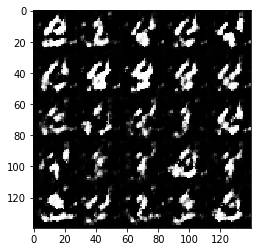

Epoch 1/2... Batch 310... Discriminator Loss: 0.6689... Generator Loss: 0.9985
Epoch 1/2... Batch 320... Discriminator Loss: 1.3089... Generator Loss: 3.9136
Epoch 1/2... Batch 330... Discriminator Loss: 1.3161... Generator Loss: 0.4365
Epoch 1/2... Batch 340... Discriminator Loss: 1.0872... Generator Loss: 1.3519
Epoch 1/2... Batch 350... Discriminator Loss: 1.0359... Generator Loss: 2.1885
Epoch 1/2... Batch 360... Discriminator Loss: 1.2318... Generator Loss: 1.4658
Epoch 1/2... Batch 370... Discriminator Loss: 1.2926... Generator Loss: 0.4981
Epoch 1/2... Batch 380... Discriminator Loss: 0.9564... Generator Loss: 3.3445
Epoch 1/2... Batch 390... Discriminator Loss: 0.7832... Generator Loss: 1.0331
Epoch 1/2... Batch 400... Discriminator Loss: 1.5672... Generator Loss: 0.3900


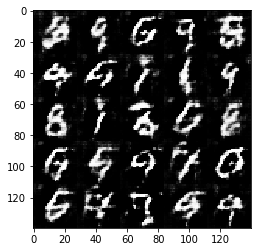

Epoch 1/2... Batch 410... Discriminator Loss: 0.8273... Generator Loss: 1.0537
Epoch 1/2... Batch 420... Discriminator Loss: 1.0747... Generator Loss: 3.2298
Epoch 1/2... Batch 430... Discriminator Loss: 0.8062... Generator Loss: 1.6375
Epoch 1/2... Batch 440... Discriminator Loss: 0.7318... Generator Loss: 2.1565
Epoch 1/2... Batch 450... Discriminator Loss: 1.3218... Generator Loss: 0.4469
Epoch 1/2... Batch 460... Discriminator Loss: 1.2434... Generator Loss: 0.4702
Epoch 1/2... Batch 470... Discriminator Loss: 1.1930... Generator Loss: 3.1872
Epoch 1/2... Batch 480... Discriminator Loss: 1.9827... Generator Loss: 0.1764
Epoch 1/2... Batch 490... Discriminator Loss: 0.8167... Generator Loss: 0.8925
Epoch 1/2... Batch 500... Discriminator Loss: 1.5003... Generator Loss: 0.3717


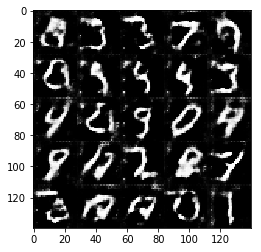

Epoch 1/2... Batch 510... Discriminator Loss: 1.8475... Generator Loss: 3.6453
Epoch 1/2... Batch 520... Discriminator Loss: 0.8375... Generator Loss: 1.1366
Epoch 1/2... Batch 530... Discriminator Loss: 1.6362... Generator Loss: 3.1194
Epoch 1/2... Batch 540... Discriminator Loss: 1.4721... Generator Loss: 0.3803
Epoch 1/2... Batch 550... Discriminator Loss: 1.8375... Generator Loss: 0.2368
Epoch 1/2... Batch 560... Discriminator Loss: 0.8802... Generator Loss: 1.4426
Epoch 1/2... Batch 570... Discriminator Loss: 0.9382... Generator Loss: 1.0612
Epoch 1/2... Batch 580... Discriminator Loss: 1.1298... Generator Loss: 0.5612
Epoch 1/2... Batch 590... Discriminator Loss: 0.8996... Generator Loss: 0.9020
Epoch 1/2... Batch 600... Discriminator Loss: 0.8233... Generator Loss: 1.1569


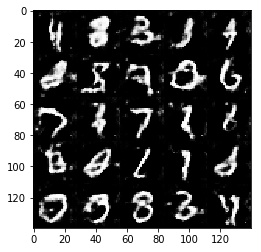

Epoch 1/2... Batch 610... Discriminator Loss: 2.0032... Generator Loss: 0.1974
Epoch 1/2... Batch 620... Discriminator Loss: 0.9322... Generator Loss: 1.2676
Epoch 1/2... Batch 630... Discriminator Loss: 0.8362... Generator Loss: 1.1559
Epoch 1/2... Batch 640... Discriminator Loss: 1.1965... Generator Loss: 0.5413
Epoch 1/2... Batch 650... Discriminator Loss: 1.5219... Generator Loss: 0.4246
Epoch 1/2... Batch 660... Discriminator Loss: 1.5216... Generator Loss: 0.3949
Epoch 1/2... Batch 670... Discriminator Loss: 1.3699... Generator Loss: 0.4679
Epoch 1/2... Batch 680... Discriminator Loss: 1.1078... Generator Loss: 0.6090
Epoch 1/2... Batch 690... Discriminator Loss: 1.3751... Generator Loss: 0.4803
Epoch 1/2... Batch 700... Discriminator Loss: 1.1628... Generator Loss: 2.0070


Epoch 1/2... Batch 710... Discriminator Loss: 1.6503... Generator Loss: 0.3469
Epoch 1/2... Batch 720... Discriminator Loss: 1.1647... Generator Loss: 0.8640
Epoch 1/2... Batch 730... Discriminator Loss: 1.0410... Generator Loss: 1.7293
Epoch 1/2... Batch 740... Discriminator Loss: 1.1047... Generator Loss: 0.5882
Epoch 1/2... Batch 750... Discriminator Loss: 1.5812... Generator Loss: 0.3273
Epoch 1/2... Batch 760... Discriminator Loss: 0.8843... Generator Loss: 1.1900
Epoch 1/2... Batch 770... Discriminator Loss: 1.5085... Generator Loss: 0.3802
Epoch 1/2... Batch 780... Discriminator Loss: 1.4942... Generator Loss: 0.3633
Epoch 1/2... Batch 790... Discriminator Loss: 0.9663... Generator Loss: 0.7086
Epoch 1/2... Batch 800... Discriminator Loss: 0.8415... Generator Loss: 0.9773


Epoch 1/2... Batch 810... Discriminator Loss: 1.5293... Generator Loss: 0.3442
Epoch 1/2... Batch 820... Discriminator Loss: 0.8576... Generator Loss: 1.1152
Epoch 1/2... Batch 830... Discriminator Loss: 1.0307... Generator Loss: 1.8259
Epoch 1/2... Batch 840... Discriminator Loss: 2.0226... Generator Loss: 0.2043
Epoch 1/2... Batch 850... Discriminator Loss: 1.3506... Generator Loss: 0.4623
Epoch 1/2... Batch 860... Discriminator Loss: 1.1714... Generator Loss: 1.4639
Epoch 1/2... Batch 870... Discriminator Loss: 0.9608... Generator Loss: 0.9817
Epoch 1/2... Batch 880... Discriminator Loss: 0.7686... Generator Loss: 1.0978
Epoch 1/2... Batch 890... Discriminator Loss: 1.3530... Generator Loss: 0.4533
Epoch 1/2... Batch 900... Discriminator Loss: 1.2408... Generator Loss: 2.0752


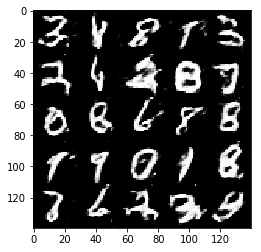

Epoch 1/2... Batch 910... Discriminator Loss: 1.3432... Generator Loss: 0.5083
Epoch 1/2... Batch 920... Discriminator Loss: 1.1197... Generator Loss: 0.6896
Epoch 1/2... Batch 930... Discriminator Loss: 0.9195... Generator Loss: 0.9032
Epoch 1/2... Batch 940... Discriminator Loss: 0.9524... Generator Loss: 1.5864
Epoch 1/2... Batch 950... Discriminator Loss: 0.9796... Generator Loss: 1.4183
Epoch 1/2... Batch 960... Discriminator Loss: 0.7845... Generator Loss: 1.2634
Epoch 1/2... Batch 970... Discriminator Loss: 0.9963... Generator Loss: 0.7629
Epoch 1/2... Batch 980... Discriminator Loss: 1.1217... Generator Loss: 0.5749
Epoch 1/2... Batch 990... Discriminator Loss: 1.1963... Generator Loss: 0.5384
Epoch 1/2... Batch 1000... Discriminator Loss: 1.2363... Generator Loss: 0.4710


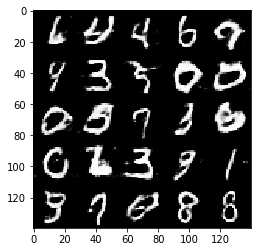

Epoch 1/2... Batch 1010... Discriminator Loss: 1.0763... Generator Loss: 0.5916
Epoch 1/2... Batch 1020... Discriminator Loss: 1.0534... Generator Loss: 0.9208
Epoch 1/2... Batch 1030... Discriminator Loss: 1.0133... Generator Loss: 0.9690
Epoch 1/2... Batch 1040... Discriminator Loss: 1.3199... Generator Loss: 0.4929
Epoch 1/2... Batch 1050... Discriminator Loss: 2.3860... Generator Loss: 0.1372
Epoch 1/2... Batch 1060... Discriminator Loss: 0.8250... Generator Loss: 1.2531
Epoch 1/2... Batch 1070... Discriminator Loss: 0.8690... Generator Loss: 1.3107
Epoch 1/2... Batch 1080... Discriminator Loss: 0.8543... Generator Loss: 1.1664
Epoch 1/2... Batch 1090... Discriminator Loss: 0.9880... Generator Loss: 1.9436
Epoch 1/2... Batch 1100... Discriminator Loss: 1.0487... Generator Loss: 0.6423


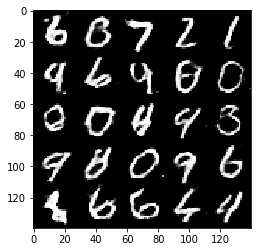

Epoch 1/2... Batch 1110... Discriminator Loss: 1.6555... Generator Loss: 0.2933
Epoch 1/2... Batch 1120... Discriminator Loss: 1.1200... Generator Loss: 0.6484
Epoch 1/2... Batch 1130... Discriminator Loss: 1.4168... Generator Loss: 0.3943
Epoch 1/2... Batch 1140... Discriminator Loss: 0.9856... Generator Loss: 0.7831
Epoch 1/2... Batch 1150... Discriminator Loss: 0.8192... Generator Loss: 1.1320
Epoch 1/2... Batch 1160... Discriminator Loss: 0.7900... Generator Loss: 1.0779
Epoch 1/2... Batch 1170... Discriminator Loss: 1.6270... Generator Loss: 2.7579
Epoch 1/2... Batch 1180... Discriminator Loss: 1.3123... Generator Loss: 0.4061
Epoch 1/2... Batch 1190... Discriminator Loss: 2.1616... Generator Loss: 0.1610
Epoch 1/2... Batch 1200... Discriminator Loss: 2.6746... Generator Loss: 0.0903


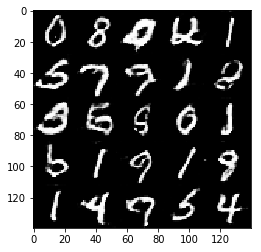

Epoch 1/2... Batch 1210... Discriminator Loss: 1.2159... Generator Loss: 0.4956
Epoch 1/2... Batch 1220... Discriminator Loss: 1.1976... Generator Loss: 0.5018
Epoch 1/2... Batch 1230... Discriminator Loss: 0.8749... Generator Loss: 0.7320
Epoch 1/2... Batch 1240... Discriminator Loss: 0.9336... Generator Loss: 1.1328
Epoch 1/2... Batch 1250... Discriminator Loss: 1.5546... Generator Loss: 0.3496
Epoch 1/2... Batch 1260... Discriminator Loss: 1.6232... Generator Loss: 0.2835
Epoch 1/2... Batch 1270... Discriminator Loss: 0.9988... Generator Loss: 0.6678
Epoch 1/2... Batch 1280... Discriminator Loss: 0.8729... Generator Loss: 1.3137
Epoch 1/2... Batch 1290... Discriminator Loss: 0.9682... Generator Loss: 0.7208
Epoch 1/2... Batch 1300... Discriminator Loss: 2.2012... Generator Loss: 0.1474


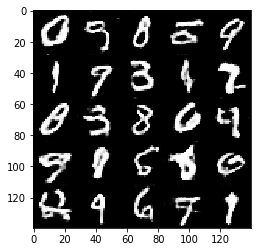

Epoch 1/2... Batch 1310... Discriminator Loss: 1.2936... Generator Loss: 0.5029
Epoch 1/2... Batch 1320... Discriminator Loss: 1.9498... Generator Loss: 0.2199
Epoch 1/2... Batch 1330... Discriminator Loss: 0.9379... Generator Loss: 0.9503
Epoch 1/2... Batch 1340... Discriminator Loss: 1.3836... Generator Loss: 0.4666
Epoch 1/2... Batch 1350... Discriminator Loss: 2.5009... Generator Loss: 0.1052
Epoch 1/2... Batch 1360... Discriminator Loss: 0.9092... Generator Loss: 1.5094
Epoch 1/2... Batch 1370... Discriminator Loss: 1.0264... Generator Loss: 0.7930
Epoch 1/2... Batch 1380... Discriminator Loss: 1.6392... Generator Loss: 0.2774
Epoch 1/2... Batch 1390... Discriminator Loss: 1.6787... Generator Loss: 0.3395
Epoch 1/2... Batch 1400... Discriminator Loss: 0.8089... Generator Loss: 1.3029


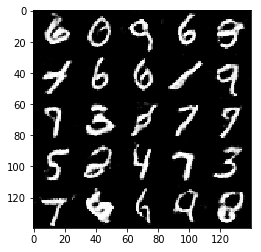

Epoch 1/2... Batch 1410... Discriminator Loss: 1.3201... Generator Loss: 2.3503
Epoch 1/2... Batch 1420... Discriminator Loss: 0.7479... Generator Loss: 2.2407
Epoch 1/2... Batch 1430... Discriminator Loss: 2.1421... Generator Loss: 0.2360
Epoch 1/2... Batch 1440... Discriminator Loss: 0.9888... Generator Loss: 2.2138
Epoch 1/2... Batch 1450... Discriminator Loss: 1.3428... Generator Loss: 1.4841
Epoch 1/2... Batch 1460... Discriminator Loss: 1.0308... Generator Loss: 0.7450
Epoch 1/2... Batch 1470... Discriminator Loss: 1.3342... Generator Loss: 0.5241
Epoch 1/2... Batch 1480... Discriminator Loss: 1.4495... Generator Loss: 0.4196
Epoch 1/2... Batch 1490... Discriminator Loss: 1.1585... Generator Loss: 0.8952
Epoch 1/2... Batch 1500... Discriminator Loss: 1.1935... Generator Loss: 0.5163


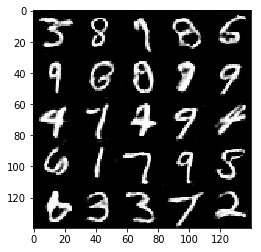

Epoch 1/2... Batch 1510... Discriminator Loss: 1.2725... Generator Loss: 0.5295
Epoch 1/2... Batch 1520... Discriminator Loss: 0.9672... Generator Loss: 1.2043
Epoch 1/2... Batch 1530... Discriminator Loss: 1.0551... Generator Loss: 0.6328
Epoch 1/2... Batch 1540... Discriminator Loss: 1.0496... Generator Loss: 0.6049
Epoch 1/2... Batch 1550... Discriminator Loss: 1.3649... Generator Loss: 0.4840
Epoch 1/2... Batch 1560... Discriminator Loss: 1.1128... Generator Loss: 0.6684
Epoch 1/2... Batch 1570... Discriminator Loss: 0.9425... Generator Loss: 1.5441
Epoch 1/2... Batch 1580... Discriminator Loss: 0.9047... Generator Loss: 0.8328
Epoch 1/2... Batch 1590... Discriminator Loss: 0.9426... Generator Loss: 0.9910
Epoch 1/2... Batch 1600... Discriminator Loss: 1.1928... Generator Loss: 0.8481


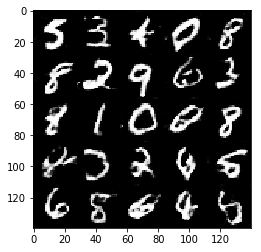

Epoch 1/2... Batch 1610... Discriminator Loss: 1.1371... Generator Loss: 0.6999
Epoch 1/2... Batch 1620... Discriminator Loss: 1.4648... Generator Loss: 0.3336
Epoch 1/2... Batch 1630... Discriminator Loss: 1.9158... Generator Loss: 0.2140
Epoch 1/2... Batch 1640... Discriminator Loss: 1.3211... Generator Loss: 2.2268
Epoch 1/2... Batch 1650... Discriminator Loss: 1.6292... Generator Loss: 2.2246
Epoch 1/2... Batch 1660... Discriminator Loss: 1.3279... Generator Loss: 0.4857
Epoch 1/2... Batch 1670... Discriminator Loss: 1.4640... Generator Loss: 0.3968
Epoch 1/2... Batch 1680... Discriminator Loss: 0.9428... Generator Loss: 0.7982
Epoch 1/2... Batch 1690... Discriminator Loss: 0.8188... Generator Loss: 0.8518
Epoch 1/2... Batch 1700... Discriminator Loss: 0.8284... Generator Loss: 1.4374


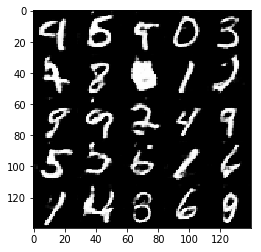

Epoch 1/2... Batch 1710... Discriminator Loss: 0.8438... Generator Loss: 0.8088
Epoch 1/2... Batch 1720... Discriminator Loss: 1.1200... Generator Loss: 2.0079
Epoch 1/2... Batch 1730... Discriminator Loss: 0.9737... Generator Loss: 0.9697
Epoch 1/2... Batch 1740... Discriminator Loss: 1.6015... Generator Loss: 0.2907
Epoch 1/2... Batch 1750... Discriminator Loss: 1.0620... Generator Loss: 1.2706
Epoch 1/2... Batch 1760... Discriminator Loss: 0.8969... Generator Loss: 1.3086
Epoch 1/2... Batch 1770... Discriminator Loss: 1.2042... Generator Loss: 1.9149
Epoch 1/2... Batch 1780... Discriminator Loss: 0.8825... Generator Loss: 1.0432
Epoch 1/2... Batch 1790... Discriminator Loss: 0.8328... Generator Loss: 1.4212
Epoch 1/2... Batch 1800... Discriminator Loss: 1.2268... Generator Loss: 0.4799


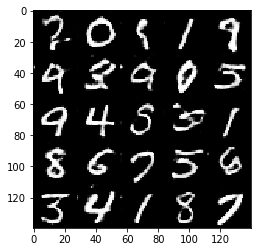

Epoch 1/2... Batch 1810... Discriminator Loss: 1.0593... Generator Loss: 0.6179
Epoch 1/2... Batch 1820... Discriminator Loss: 0.9975... Generator Loss: 0.7643
Epoch 1/2... Batch 1830... Discriminator Loss: 1.1337... Generator Loss: 0.6799
Epoch 1/2... Batch 1840... Discriminator Loss: 1.5732... Generator Loss: 0.2978
Epoch 1/2... Batch 1850... Discriminator Loss: 0.8747... Generator Loss: 1.5765
Epoch 1/2... Batch 1860... Discriminator Loss: 0.9350... Generator Loss: 0.8484
Epoch 1/2... Batch 1870... Discriminator Loss: 0.8984... Generator Loss: 0.9914
Epoch 2/2... Batch 10... Discriminator Loss: 1.1494... Generator Loss: 3.1181
Epoch 2/2... Batch 20... Discriminator Loss: 1.2535... Generator Loss: 0.4876
Epoch 2/2... Batch 30... Discriminator Loss: 1.1796... Generator Loss: 0.7601
Epoch 2/2... Batch 40... Discriminator Loss: 1.0830... Generator Loss: 1.5729
Epoch 2/2... Batch 50... Discriminator Loss: 1.9647... Generator Loss: 0.2240
Epoch 2/2... Batch 60... Discriminator Loss: 1.592

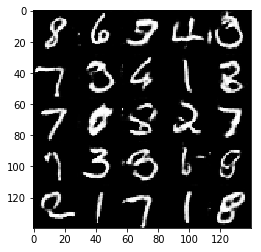

Epoch 2/2... Batch 110... Discriminator Loss: 1.5802... Generator Loss: 0.4166
Epoch 2/2... Batch 120... Discriminator Loss: 1.1542... Generator Loss: 0.6503
Epoch 2/2... Batch 130... Discriminator Loss: 1.1000... Generator Loss: 0.6889
Epoch 2/2... Batch 140... Discriminator Loss: 1.9940... Generator Loss: 0.1810
Epoch 2/2... Batch 150... Discriminator Loss: 1.0732... Generator Loss: 0.6871
Epoch 2/2... Batch 160... Discriminator Loss: 0.7994... Generator Loss: 1.1055
Epoch 2/2... Batch 170... Discriminator Loss: 1.3418... Generator Loss: 0.4288
Epoch 2/2... Batch 180... Discriminator Loss: 1.6331... Generator Loss: 0.2992
Epoch 2/2... Batch 190... Discriminator Loss: 1.1003... Generator Loss: 2.5100
Epoch 2/2... Batch 200... Discriminator Loss: 0.7769... Generator Loss: 0.9031


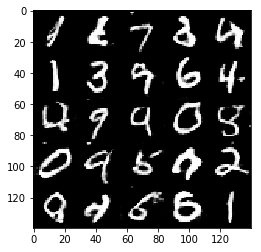

Epoch 2/2... Batch 210... Discriminator Loss: 1.9949... Generator Loss: 0.2424
Epoch 2/2... Batch 220... Discriminator Loss: 1.2489... Generator Loss: 0.5172
Epoch 2/2... Batch 230... Discriminator Loss: 0.9571... Generator Loss: 0.9265
Epoch 2/2... Batch 240... Discriminator Loss: 1.1309... Generator Loss: 1.8658
Epoch 2/2... Batch 250... Discriminator Loss: 0.8719... Generator Loss: 1.3946
Epoch 2/2... Batch 260... Discriminator Loss: 1.2872... Generator Loss: 0.4872
Epoch 2/2... Batch 270... Discriminator Loss: 1.2693... Generator Loss: 0.5135
Epoch 2/2... Batch 280... Discriminator Loss: 0.9728... Generator Loss: 0.7309
Epoch 2/2... Batch 290... Discriminator Loss: 1.2182... Generator Loss: 1.8935
Epoch 2/2... Batch 300... Discriminator Loss: 0.7188... Generator Loss: 2.0702


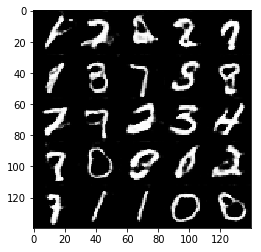

Epoch 2/2... Batch 310... Discriminator Loss: 0.9995... Generator Loss: 0.7642
Epoch 2/2... Batch 320... Discriminator Loss: 1.9248... Generator Loss: 4.3131
Epoch 2/2... Batch 330... Discriminator Loss: 0.9266... Generator Loss: 1.5225
Epoch 2/2... Batch 340... Discriminator Loss: 0.9372... Generator Loss: 0.9172
Epoch 2/2... Batch 350... Discriminator Loss: 1.1024... Generator Loss: 0.5998
Epoch 2/2... Batch 360... Discriminator Loss: 1.0033... Generator Loss: 0.8662
Epoch 2/2... Batch 370... Discriminator Loss: 0.6352... Generator Loss: 2.3080
Epoch 2/2... Batch 380... Discriminator Loss: 2.2211... Generator Loss: 0.1893
Epoch 2/2... Batch 390... Discriminator Loss: 0.7112... Generator Loss: 1.5808
Epoch 2/2... Batch 400... Discriminator Loss: 1.9679... Generator Loss: 0.2196


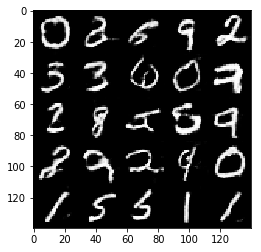

Epoch 2/2... Batch 410... Discriminator Loss: 1.1246... Generator Loss: 0.6430
Epoch 2/2... Batch 420... Discriminator Loss: 0.9493... Generator Loss: 1.1412
Epoch 2/2... Batch 430... Discriminator Loss: 2.6629... Generator Loss: 0.0977
Epoch 2/2... Batch 440... Discriminator Loss: 1.9378... Generator Loss: 0.2088
Epoch 2/2... Batch 450... Discriminator Loss: 1.4243... Generator Loss: 2.7430
Epoch 2/2... Batch 460... Discriminator Loss: 0.8391... Generator Loss: 1.3752
Epoch 2/2... Batch 470... Discriminator Loss: 1.4412... Generator Loss: 0.3836
Epoch 2/2... Batch 480... Discriminator Loss: 1.1488... Generator Loss: 0.5170
Epoch 2/2... Batch 490... Discriminator Loss: 0.6143... Generator Loss: 1.3101
Epoch 2/2... Batch 500... Discriminator Loss: 0.7532... Generator Loss: 0.9689


Epoch 2/2... Batch 510... Discriminator Loss: 1.8853... Generator Loss: 0.2579
Epoch 2/2... Batch 520... Discriminator Loss: 1.3740... Generator Loss: 3.2766
Epoch 2/2... Batch 530... Discriminator Loss: 1.6746... Generator Loss: 0.3249
Epoch 2/2... Batch 540... Discriminator Loss: 0.6589... Generator Loss: 1.7198
Epoch 2/2... Batch 550... Discriminator Loss: 3.1674... Generator Loss: 0.0613
Epoch 2/2... Batch 560... Discriminator Loss: 0.4590... Generator Loss: 1.8682
Epoch 2/2... Batch 570... Discriminator Loss: 1.8485... Generator Loss: 0.2585
Epoch 2/2... Batch 580... Discriminator Loss: 0.6273... Generator Loss: 1.3188
Epoch 2/2... Batch 590... Discriminator Loss: 1.0187... Generator Loss: 0.7193
Epoch 2/2... Batch 600... Discriminator Loss: 2.1633... Generator Loss: 0.1570


Epoch 2/2... Batch 610... Discriminator Loss: 1.1604... Generator Loss: 2.6606
Epoch 2/2... Batch 620... Discriminator Loss: 1.7026... Generator Loss: 0.4190
Epoch 2/2... Batch 630... Discriminator Loss: 0.7255... Generator Loss: 1.0424
Epoch 2/2... Batch 640... Discriminator Loss: 1.5754... Generator Loss: 0.3137
Epoch 2/2... Batch 650... Discriminator Loss: 0.7364... Generator Loss: 1.5460
Epoch 2/2... Batch 660... Discriminator Loss: 1.6514... Generator Loss: 0.3664
Epoch 2/2... Batch 670... Discriminator Loss: 1.8359... Generator Loss: 0.2155
Epoch 2/2... Batch 680... Discriminator Loss: 0.9156... Generator Loss: 0.9751
Epoch 2/2... Batch 690... Discriminator Loss: 1.0784... Generator Loss: 3.0736
Epoch 2/2... Batch 700... Discriminator Loss: 0.5191... Generator Loss: 1.8759


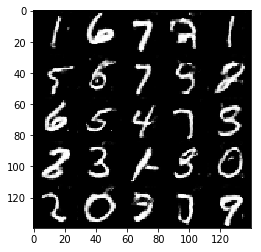

Epoch 2/2... Batch 710... Discriminator Loss: 1.1853... Generator Loss: 0.5478
Epoch 2/2... Batch 720... Discriminator Loss: 0.5495... Generator Loss: 1.3354
Epoch 2/2... Batch 730... Discriminator Loss: 1.7632... Generator Loss: 0.3245
Epoch 2/2... Batch 740... Discriminator Loss: 1.0167... Generator Loss: 0.6681
Epoch 2/2... Batch 750... Discriminator Loss: 0.8372... Generator Loss: 0.9679
Epoch 2/2... Batch 760... Discriminator Loss: 1.6457... Generator Loss: 0.3234
Epoch 2/2... Batch 770... Discriminator Loss: 1.4583... Generator Loss: 0.3440
Epoch 2/2... Batch 780... Discriminator Loss: 2.8247... Generator Loss: 0.1041
Epoch 2/2... Batch 790... Discriminator Loss: 0.5925... Generator Loss: 3.0039
Epoch 2/2... Batch 800... Discriminator Loss: 1.0646... Generator Loss: 0.5816


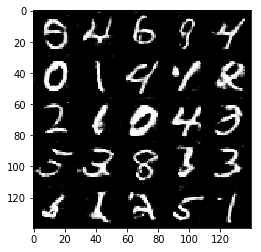

Epoch 2/2... Batch 810... Discriminator Loss: 0.8918... Generator Loss: 0.8301
Epoch 2/2... Batch 820... Discriminator Loss: 1.0029... Generator Loss: 0.7159
Epoch 2/2... Batch 830... Discriminator Loss: 1.8466... Generator Loss: 0.3033
Epoch 2/2... Batch 840... Discriminator Loss: 1.9050... Generator Loss: 0.2456
Epoch 2/2... Batch 850... Discriminator Loss: 2.0522... Generator Loss: 0.2242
Epoch 2/2... Batch 860... Discriminator Loss: 1.0087... Generator Loss: 0.6003
Epoch 2/2... Batch 870... Discriminator Loss: 0.5095... Generator Loss: 1.6399
Epoch 2/2... Batch 880... Discriminator Loss: 0.7914... Generator Loss: 0.9738
Epoch 2/2... Batch 890... Discriminator Loss: 1.6405... Generator Loss: 0.3319
Epoch 2/2... Batch 900... Discriminator Loss: 1.3971... Generator Loss: 0.4306


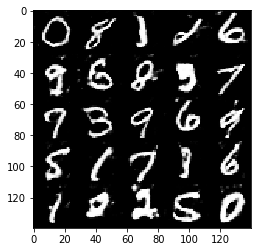

Epoch 2/2... Batch 910... Discriminator Loss: 0.5750... Generator Loss: 1.1481
Epoch 2/2... Batch 920... Discriminator Loss: 0.9096... Generator Loss: 0.9165
Epoch 2/2... Batch 930... Discriminator Loss: 1.7684... Generator Loss: 0.2907
Epoch 2/2... Batch 940... Discriminator Loss: 1.3005... Generator Loss: 0.4316
Epoch 2/2... Batch 950... Discriminator Loss: 0.5151... Generator Loss: 1.6056
Epoch 2/2... Batch 960... Discriminator Loss: 1.0584... Generator Loss: 1.1197
Epoch 2/2... Batch 970... Discriminator Loss: 0.6155... Generator Loss: 1.2753
Epoch 2/2... Batch 980... Discriminator Loss: 0.8258... Generator Loss: 0.8880
Epoch 2/2... Batch 990... Discriminator Loss: 2.3524... Generator Loss: 0.1472
Epoch 2/2... Batch 1000... Discriminator Loss: 0.7452... Generator Loss: 1.0143


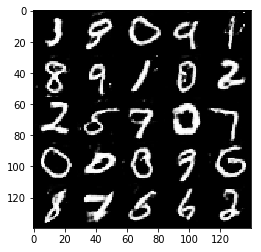

Epoch 2/2... Batch 1010... Discriminator Loss: 1.0338... Generator Loss: 0.6531
Epoch 2/2... Batch 1020... Discriminator Loss: 0.6970... Generator Loss: 1.4972
Epoch 2/2... Batch 1030... Discriminator Loss: 0.5395... Generator Loss: 1.3232
Epoch 2/2... Batch 1040... Discriminator Loss: 1.0725... Generator Loss: 0.6429
Epoch 2/2... Batch 1050... Discriminator Loss: 0.4142... Generator Loss: 1.7455
Epoch 2/2... Batch 1060... Discriminator Loss: 0.4958... Generator Loss: 2.1008
Epoch 2/2... Batch 1070... Discriminator Loss: 1.4037... Generator Loss: 0.4671
Epoch 2/2... Batch 1080... Discriminator Loss: 0.5002... Generator Loss: 1.5072
Epoch 2/2... Batch 1090... Discriminator Loss: 0.6999... Generator Loss: 1.0079
Epoch 2/2... Batch 1100... Discriminator Loss: 0.5542... Generator Loss: 1.4665


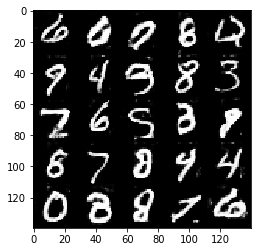

Epoch 2/2... Batch 1110... Discriminator Loss: 0.8649... Generator Loss: 3.0066
Epoch 2/2... Batch 1120... Discriminator Loss: 2.6755... Generator Loss: 0.1816
Epoch 2/2... Batch 1130... Discriminator Loss: 2.0920... Generator Loss: 0.1793
Epoch 2/2... Batch 1140... Discriminator Loss: 0.6335... Generator Loss: 2.5725
Epoch 2/2... Batch 1150... Discriminator Loss: 1.0636... Generator Loss: 0.6631
Epoch 2/2... Batch 1160... Discriminator Loss: 0.3828... Generator Loss: 2.1211
Epoch 2/2... Batch 1170... Discriminator Loss: 2.1369... Generator Loss: 0.2499
Epoch 2/2... Batch 1180... Discriminator Loss: 2.9818... Generator Loss: 0.1262
Epoch 2/2... Batch 1190... Discriminator Loss: 1.3301... Generator Loss: 0.4739
Epoch 2/2... Batch 1200... Discriminator Loss: 0.6733... Generator Loss: 1.1537


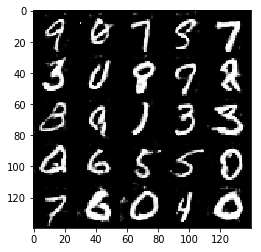

Epoch 2/2... Batch 1210... Discriminator Loss: 1.2909... Generator Loss: 0.5203
Epoch 2/2... Batch 1220... Discriminator Loss: 0.7719... Generator Loss: 0.9180
Epoch 2/2... Batch 1230... Discriminator Loss: 1.3892... Generator Loss: 0.4046
Epoch 2/2... Batch 1240... Discriminator Loss: 1.7497... Generator Loss: 0.3605
Epoch 2/2... Batch 1250... Discriminator Loss: 1.8950... Generator Loss: 3.5817
Epoch 2/2... Batch 1260... Discriminator Loss: 2.1873... Generator Loss: 0.2723
Epoch 2/2... Batch 1270... Discriminator Loss: 0.6764... Generator Loss: 1.2895
Epoch 2/2... Batch 1280... Discriminator Loss: 0.7485... Generator Loss: 0.9456
Epoch 2/2... Batch 1290... Discriminator Loss: 1.1659... Generator Loss: 0.5695
Epoch 2/2... Batch 1300... Discriminator Loss: 0.8099... Generator Loss: 1.0990


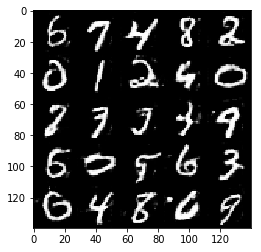

Epoch 2/2... Batch 1310... Discriminator Loss: 0.8708... Generator Loss: 0.8860
Epoch 2/2... Batch 1320... Discriminator Loss: 0.7792... Generator Loss: 3.3242
Epoch 2/2... Batch 1330... Discriminator Loss: 0.5597... Generator Loss: 1.4861
Epoch 2/2... Batch 1340... Discriminator Loss: 0.6751... Generator Loss: 2.3492
Epoch 2/2... Batch 1350... Discriminator Loss: 1.7131... Generator Loss: 0.3451
Epoch 2/2... Batch 1360... Discriminator Loss: 0.8475... Generator Loss: 3.4518
Epoch 2/2... Batch 1370... Discriminator Loss: 0.5590... Generator Loss: 1.6164
Epoch 2/2... Batch 1380... Discriminator Loss: 0.4126... Generator Loss: 2.8743
Epoch 2/2... Batch 1390... Discriminator Loss: 2.0246... Generator Loss: 0.2150
Epoch 2/2... Batch 1400... Discriminator Loss: 1.0928... Generator Loss: 0.7080


Epoch 2/2... Batch 1410... Discriminator Loss: 0.7111... Generator Loss: 0.9143
Epoch 2/2... Batch 1420... Discriminator Loss: 0.3380... Generator Loss: 3.2184
Epoch 2/2... Batch 1430... Discriminator Loss: 1.2443... Generator Loss: 0.7452
Epoch 2/2... Batch 1440... Discriminator Loss: 0.4968... Generator Loss: 1.7176
Epoch 2/2... Batch 1450... Discriminator Loss: 0.7899... Generator Loss: 1.4801
Epoch 2/2... Batch 1460... Discriminator Loss: 0.9090... Generator Loss: 0.8985
Epoch 2/2... Batch 1470... Discriminator Loss: 1.3327... Generator Loss: 3.8641
Epoch 2/2... Batch 1480... Discriminator Loss: 0.9380... Generator Loss: 0.7840
Epoch 2/2... Batch 1490... Discriminator Loss: 1.2025... Generator Loss: 0.5532
Epoch 2/2... Batch 1500... Discriminator Loss: 1.3946... Generator Loss: 0.4057


Epoch 2/2... Batch 1510... Discriminator Loss: 0.8348... Generator Loss: 0.8397
Epoch 2/2... Batch 1520... Discriminator Loss: 0.8908... Generator Loss: 1.0776
Epoch 2/2... Batch 1530... Discriminator Loss: 1.4118... Generator Loss: 0.4481
Epoch 2/2... Batch 1540... Discriminator Loss: 0.3226... Generator Loss: 2.0702
Epoch 2/2... Batch 1550... Discriminator Loss: 1.4697... Generator Loss: 0.3441
Epoch 2/2... Batch 1560... Discriminator Loss: 0.9111... Generator Loss: 0.7642
Epoch 2/2... Batch 1570... Discriminator Loss: 1.1302... Generator Loss: 0.5634
Epoch 2/2... Batch 1580... Discriminator Loss: 0.4893... Generator Loss: 2.2332
Epoch 2/2... Batch 1590... Discriminator Loss: 2.0619... Generator Loss: 0.2479
Epoch 2/2... Batch 1600... Discriminator Loss: 3.4796... Generator Loss: 0.0501


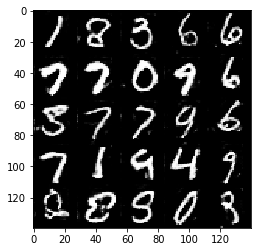

Epoch 2/2... Batch 1610... Discriminator Loss: 2.9344... Generator Loss: 0.0854
Epoch 2/2... Batch 1620... Discriminator Loss: 1.1070... Generator Loss: 0.5998
Epoch 2/2... Batch 1630... Discriminator Loss: 2.3749... Generator Loss: 0.1708
Epoch 2/2... Batch 1640... Discriminator Loss: 0.9250... Generator Loss: 1.5631
Epoch 2/2... Batch 1650... Discriminator Loss: 0.8339... Generator Loss: 2.9643
Epoch 2/2... Batch 1660... Discriminator Loss: 0.7911... Generator Loss: 0.9039
Epoch 2/2... Batch 1670... Discriminator Loss: 0.4423... Generator Loss: 1.5706
Epoch 2/2... Batch 1680... Discriminator Loss: 0.9170... Generator Loss: 0.7796
Epoch 2/2... Batch 1690... Discriminator Loss: 1.5690... Generator Loss: 0.4382
Epoch 2/2... Batch 1700... Discriminator Loss: 0.5198... Generator Loss: 1.9287


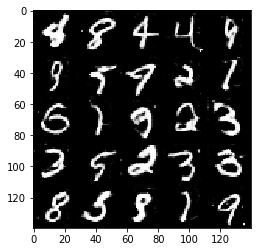

Epoch 2/2... Batch 1710... Discriminator Loss: 2.5871... Generator Loss: 0.1629
Epoch 2/2... Batch 1720... Discriminator Loss: 0.9855... Generator Loss: 0.7370
Epoch 2/2... Batch 1730... Discriminator Loss: 0.6717... Generator Loss: 1.8998
Epoch 2/2... Batch 1740... Discriminator Loss: 0.6512... Generator Loss: 2.3157
Epoch 2/2... Batch 1750... Discriminator Loss: 1.9979... Generator Loss: 0.2581
Epoch 2/2... Batch 1760... Discriminator Loss: 1.8432... Generator Loss: 0.2694
Epoch 2/2... Batch 1770... Discriminator Loss: 0.6774... Generator Loss: 1.0197
Epoch 2/2... Batch 1780... Discriminator Loss: 0.4408... Generator Loss: 1.4379
Epoch 2/2... Batch 1790... Discriminator Loss: 0.6373... Generator Loss: 1.4621
Epoch 2/2... Batch 1800... Discriminator Loss: 0.3478... Generator Loss: 1.7969


Epoch 2/2... Batch 1810... Discriminator Loss: 0.6524... Generator Loss: 1.6945
Epoch 2/2... Batch 1820... Discriminator Loss: 1.0231... Generator Loss: 1.0008
Epoch 2/2... Batch 1830... Discriminator Loss: 1.2495... Generator Loss: 0.4479
Epoch 2/2... Batch 1840... Discriminator Loss: 1.0553... Generator Loss: 0.6613
Epoch 2/2... Batch 1850... Discriminator Loss: 0.6939... Generator Loss: 1.0974
Epoch 2/2... Batch 1860... Discriminator Loss: 1.8617... Generator Loss: 0.2433
Epoch 2/2... Batch 1870... Discriminator Loss: 0.7825... Generator Loss: 0.8500


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.1809... Generator Loss: 16.5037
Epoch 1/1... Batch 20... Discriminator Loss: 0.0948... Generator Loss: 6.1842
Epoch 1/1... Batch 30... Discriminator Loss: 3.0025... Generator Loss: 12.7487
Epoch 1/1... Batch 40... Discriminator Loss: 0.4698... Generator Loss: 4.2087
Epoch 1/1... Batch 50... Discriminator Loss: 1.2391... Generator Loss: 3.0904
Epoch 1/1... Batch 60... Discriminator Loss: 1.2628... Generator Loss: 0.5072
Epoch 1/1... Batch 70... Discriminator Loss: 0.7330... Generator Loss: 1.4166
Epoch 1/1... Batch 80... Discriminator Loss: 0.8326... Generator Loss: 4.3241
Epoch 1/1... Batch 90... Discriminator Loss: 0.6660... Generator Loss: 6.5351
Epoch 1/1... Batch 100... Discriminator Loss: 1.1415... Generator Loss: 0.5830


Epoch 1/1... Batch 110... Discriminator Loss: 0.9414... Generator Loss: 1.4170
Epoch 1/1... Batch 120... Discriminator Loss: 2.2746... Generator Loss: 3.2972
Epoch 1/1... Batch 130... Discriminator Loss: 1.0533... Generator Loss: 0.5463
Epoch 1/1... Batch 140... Discriminator Loss: 1.4249... Generator Loss: 0.4357
Epoch 1/1... Batch 150... Discriminator Loss: 0.4887... Generator Loss: 3.8288
Epoch 1/1... Batch 160... Discriminator Loss: 1.2521... Generator Loss: 2.5758
Epoch 1/1... Batch 170... Discriminator Loss: 0.9155... Generator Loss: 1.0174
Epoch 1/1... Batch 180... Discriminator Loss: 1.0828... Generator Loss: 3.3758
Epoch 1/1... Batch 190... Discriminator Loss: 0.4630... Generator Loss: 4.7566
Epoch 1/1... Batch 200... Discriminator Loss: 0.8027... Generator Loss: 2.9488


Epoch 1/1... Batch 210... Discriminator Loss: 1.8113... Generator Loss: 3.4201
Epoch 1/1... Batch 220... Discriminator Loss: 1.1581... Generator Loss: 0.5434
Epoch 1/1... Batch 230... Discriminator Loss: 1.2901... Generator Loss: 0.4781
Epoch 1/1... Batch 240... Discriminator Loss: 0.4823... Generator Loss: 1.6149
Epoch 1/1... Batch 250... Discriminator Loss: 1.2073... Generator Loss: 0.5205
Epoch 1/1... Batch 260... Discriminator Loss: 1.2733... Generator Loss: 3.8084
Epoch 1/1... Batch 270... Discriminator Loss: 1.0262... Generator Loss: 1.3004
Epoch 1/1... Batch 280... Discriminator Loss: 1.7689... Generator Loss: 0.2758
Epoch 1/1... Batch 290... Discriminator Loss: 1.8778... Generator Loss: 0.2804
Epoch 1/1... Batch 300... Discriminator Loss: 1.5346... Generator Loss: 0.5339


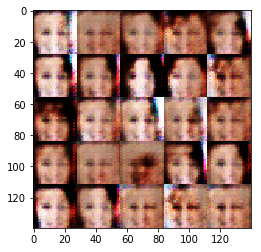

Epoch 1/1... Batch 310... Discriminator Loss: 0.8809... Generator Loss: 0.9662
Epoch 1/1... Batch 320... Discriminator Loss: 1.5075... Generator Loss: 0.3592
Epoch 1/1... Batch 330... Discriminator Loss: 0.9523... Generator Loss: 0.8001
Epoch 1/1... Batch 340... Discriminator Loss: 1.9068... Generator Loss: 4.0056
Epoch 1/1... Batch 350... Discriminator Loss: 1.5832... Generator Loss: 0.3221
Epoch 1/1... Batch 360... Discriminator Loss: 1.6010... Generator Loss: 0.3425
Epoch 1/1... Batch 370... Discriminator Loss: 0.4553... Generator Loss: 1.6426
Epoch 1/1... Batch 380... Discriminator Loss: 0.8380... Generator Loss: 1.5563
Epoch 1/1... Batch 390... Discriminator Loss: 1.1959... Generator Loss: 0.8526
Epoch 1/1... Batch 400... Discriminator Loss: 0.8026... Generator Loss: 0.9196


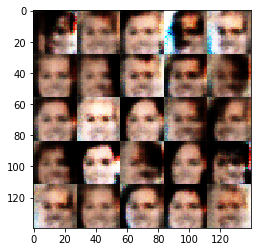

Epoch 1/1... Batch 410... Discriminator Loss: 0.6438... Generator Loss: 1.4975
Epoch 1/1... Batch 420... Discriminator Loss: 3.0617... Generator Loss: 3.2895
Epoch 1/1... Batch 430... Discriminator Loss: 0.6934... Generator Loss: 1.9441
Epoch 1/1... Batch 440... Discriminator Loss: 1.1397... Generator Loss: 2.0475
Epoch 1/1... Batch 450... Discriminator Loss: 0.8080... Generator Loss: 1.4130
Epoch 1/1... Batch 460... Discriminator Loss: 0.9427... Generator Loss: 0.8917
Epoch 1/1... Batch 470... Discriminator Loss: 2.1383... Generator Loss: 3.0164
Epoch 1/1... Batch 480... Discriminator Loss: 1.2033... Generator Loss: 0.6921
Epoch 1/1... Batch 490... Discriminator Loss: 0.9880... Generator Loss: 1.0027
Epoch 1/1... Batch 500... Discriminator Loss: 1.6034... Generator Loss: 0.3994


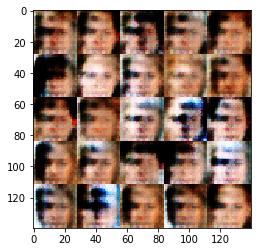

Epoch 1/1... Batch 510... Discriminator Loss: 1.2433... Generator Loss: 0.5629
Epoch 1/1... Batch 520... Discriminator Loss: 1.0978... Generator Loss: 1.5815
Epoch 1/1... Batch 530... Discriminator Loss: 1.0721... Generator Loss: 1.8418
Epoch 1/1... Batch 540... Discriminator Loss: 1.3722... Generator Loss: 1.4588
Epoch 1/1... Batch 550... Discriminator Loss: 0.8808... Generator Loss: 0.7888
Epoch 1/1... Batch 560... Discriminator Loss: 0.9858... Generator Loss: 0.7444
Epoch 1/1... Batch 570... Discriminator Loss: 0.6644... Generator Loss: 0.9227
Epoch 1/1... Batch 580... Discriminator Loss: 1.2394... Generator Loss: 1.9173
Epoch 1/1... Batch 590... Discriminator Loss: 1.3765... Generator Loss: 0.4533
Epoch 1/1... Batch 600... Discriminator Loss: 1.0963... Generator Loss: 2.6171


Epoch 1/1... Batch 610... Discriminator Loss: 0.9102... Generator Loss: 1.5771
Epoch 1/1... Batch 620... Discriminator Loss: 1.0482... Generator Loss: 1.6110
Epoch 1/1... Batch 630... Discriminator Loss: 1.5850... Generator Loss: 0.3336
Epoch 1/1... Batch 640... Discriminator Loss: 2.1530... Generator Loss: 0.1757
Epoch 1/1... Batch 650... Discriminator Loss: 3.7625... Generator Loss: 5.4055
Epoch 1/1... Batch 660... Discriminator Loss: 1.2060... Generator Loss: 0.6319
Epoch 1/1... Batch 670... Discriminator Loss: 0.8151... Generator Loss: 0.8471
Epoch 1/1... Batch 680... Discriminator Loss: 0.9008... Generator Loss: 0.7242
Epoch 1/1... Batch 690... Discriminator Loss: 1.5827... Generator Loss: 0.3370
Epoch 1/1... Batch 700... Discriminator Loss: 0.4804... Generator Loss: 1.5211


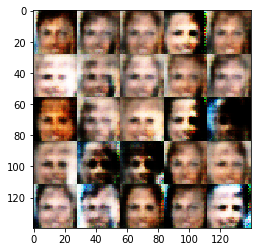

Epoch 1/1... Batch 710... Discriminator Loss: 1.3382... Generator Loss: 2.4778
Epoch 1/1... Batch 720... Discriminator Loss: 1.6350... Generator Loss: 2.3577
Epoch 1/1... Batch 730... Discriminator Loss: 0.8953... Generator Loss: 0.8349
Epoch 1/1... Batch 740... Discriminator Loss: 0.6534... Generator Loss: 0.9608
Epoch 1/1... Batch 750... Discriminator Loss: 1.6404... Generator Loss: 0.3561
Epoch 1/1... Batch 760... Discriminator Loss: 0.7208... Generator Loss: 1.7093
Epoch 1/1... Batch 770... Discriminator Loss: 0.8333... Generator Loss: 1.8873
Epoch 1/1... Batch 780... Discriminator Loss: 1.1778... Generator Loss: 1.9091
Epoch 1/1... Batch 790... Discriminator Loss: 2.0549... Generator Loss: 2.8360
Epoch 1/1... Batch 800... Discriminator Loss: 1.0266... Generator Loss: 1.5812


Epoch 1/1... Batch 810... Discriminator Loss: 0.8476... Generator Loss: 0.7315
Epoch 1/1... Batch 820... Discriminator Loss: 0.9770... Generator Loss: 0.6575
Epoch 1/1... Batch 830... Discriminator Loss: 0.8672... Generator Loss: 1.4864
Epoch 1/1... Batch 840... Discriminator Loss: 0.7082... Generator Loss: 0.8947
Epoch 1/1... Batch 850... Discriminator Loss: 1.3507... Generator Loss: 0.4179
Epoch 1/1... Batch 860... Discriminator Loss: 0.7916... Generator Loss: 1.0244
Epoch 1/1... Batch 870... Discriminator Loss: 1.0619... Generator Loss: 0.7627
Epoch 1/1... Batch 880... Discriminator Loss: 1.1498... Generator Loss: 0.5288
Epoch 1/1... Batch 890... Discriminator Loss: 0.8789... Generator Loss: 1.3739
Epoch 1/1... Batch 900... Discriminator Loss: 1.2778... Generator Loss: 0.5686


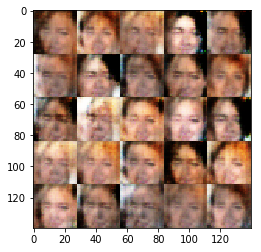

Epoch 1/1... Batch 910... Discriminator Loss: 1.3979... Generator Loss: 0.5884
Epoch 1/1... Batch 920... Discriminator Loss: 0.8525... Generator Loss: 0.9030
Epoch 1/1... Batch 930... Discriminator Loss: 1.0828... Generator Loss: 1.4849
Epoch 1/1... Batch 940... Discriminator Loss: 0.5717... Generator Loss: 1.0707
Epoch 1/1... Batch 950... Discriminator Loss: 1.2890... Generator Loss: 0.4293
Epoch 1/1... Batch 960... Discriminator Loss: 1.0737... Generator Loss: 1.6322
Epoch 1/1... Batch 970... Discriminator Loss: 1.0321... Generator Loss: 0.8105
Epoch 1/1... Batch 980... Discriminator Loss: 1.1735... Generator Loss: 1.5163
Epoch 1/1... Batch 990... Discriminator Loss: 0.8749... Generator Loss: 1.1638
Epoch 1/1... Batch 1000... Discriminator Loss: 2.3868... Generator Loss: 3.3305


Epoch 1/1... Batch 1010... Discriminator Loss: 1.4526... Generator Loss: 0.4045
Epoch 1/1... Batch 1020... Discriminator Loss: 0.9429... Generator Loss: 0.9262
Epoch 1/1... Batch 1030... Discriminator Loss: 0.6437... Generator Loss: 1.7995
Epoch 1/1... Batch 1040... Discriminator Loss: 1.0748... Generator Loss: 1.6278
Epoch 1/1... Batch 1050... Discriminator Loss: 1.2148... Generator Loss: 0.4784
Epoch 1/1... Batch 1060... Discriminator Loss: 0.4461... Generator Loss: 5.0961
Epoch 1/1... Batch 1070... Discriminator Loss: 1.4490... Generator Loss: 1.5068
Epoch 1/1... Batch 1080... Discriminator Loss: 1.3235... Generator Loss: 1.0831
Epoch 1/1... Batch 1090... Discriminator Loss: 0.8274... Generator Loss: 1.0761
Epoch 1/1... Batch 1100... Discriminator Loss: 1.2431... Generator Loss: 0.4259


Epoch 1/1... Batch 1110... Discriminator Loss: 1.9524... Generator Loss: 3.8874
Epoch 1/1... Batch 1120... Discriminator Loss: 0.5085... Generator Loss: 1.9037
Epoch 1/1... Batch 1130... Discriminator Loss: 1.4351... Generator Loss: 0.5679
Epoch 1/1... Batch 1140... Discriminator Loss: 2.0231... Generator Loss: 0.1948
Epoch 1/1... Batch 1150... Discriminator Loss: 0.7726... Generator Loss: 0.8520
Epoch 1/1... Batch 1160... Discriminator Loss: 0.7163... Generator Loss: 0.8579
Epoch 1/1... Batch 1170... Discriminator Loss: 1.7178... Generator Loss: 0.2892
Epoch 1/1... Batch 1180... Discriminator Loss: 1.1714... Generator Loss: 0.5074
Epoch 1/1... Batch 1190... Discriminator Loss: 0.5280... Generator Loss: 1.2455
Epoch 1/1... Batch 1200... Discriminator Loss: 1.3792... Generator Loss: 0.3886


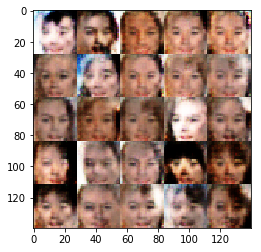

Epoch 1/1... Batch 1210... Discriminator Loss: 1.4314... Generator Loss: 1.0876
Epoch 1/1... Batch 1220... Discriminator Loss: 1.1110... Generator Loss: 2.5233
Epoch 1/1... Batch 1230... Discriminator Loss: 1.6625... Generator Loss: 0.3184
Epoch 1/1... Batch 1240... Discriminator Loss: 1.2617... Generator Loss: 1.5325
Epoch 1/1... Batch 1250... Discriminator Loss: 0.8911... Generator Loss: 0.8458
Epoch 1/1... Batch 1260... Discriminator Loss: 1.1587... Generator Loss: 0.5559
Epoch 1/1... Batch 1270... Discriminator Loss: 0.9397... Generator Loss: 0.7029
Epoch 1/1... Batch 1280... Discriminator Loss: 1.0825... Generator Loss: 0.8012
Epoch 1/1... Batch 1290... Discriminator Loss: 1.3204... Generator Loss: 0.3756
Epoch 1/1... Batch 1300... Discriminator Loss: 1.6920... Generator Loss: 0.2630


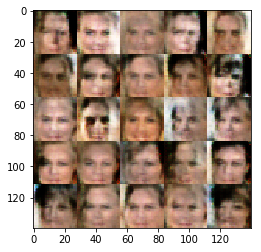

Epoch 1/1... Batch 1310... Discriminator Loss: 0.6720... Generator Loss: 1.3968
Epoch 1/1... Batch 1320... Discriminator Loss: 2.9820... Generator Loss: 3.5772
Epoch 1/1... Batch 1330... Discriminator Loss: 1.0835... Generator Loss: 0.6324
Epoch 1/1... Batch 1340... Discriminator Loss: 2.1048... Generator Loss: 0.1672
Epoch 1/1... Batch 1350... Discriminator Loss: 1.3618... Generator Loss: 0.3935
Epoch 1/1... Batch 1360... Discriminator Loss: 0.9738... Generator Loss: 1.5218
Epoch 1/1... Batch 1370... Discriminator Loss: 1.5417... Generator Loss: 0.3748
Epoch 1/1... Batch 1380... Discriminator Loss: 0.8699... Generator Loss: 2.3322
Epoch 1/1... Batch 1390... Discriminator Loss: 0.6472... Generator Loss: 1.6600
Epoch 1/1... Batch 1400... Discriminator Loss: 1.5922... Generator Loss: 0.3299


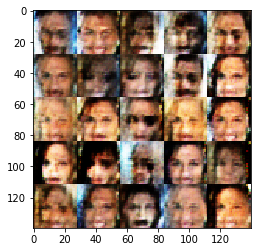

Epoch 1/1... Batch 1410... Discriminator Loss: 1.3221... Generator Loss: 2.3058
Epoch 1/1... Batch 1420... Discriminator Loss: 1.0935... Generator Loss: 0.8322
Epoch 1/1... Batch 1430... Discriminator Loss: 1.2466... Generator Loss: 2.0969
Epoch 1/1... Batch 1440... Discriminator Loss: 0.8908... Generator Loss: 0.7578
Epoch 1/1... Batch 1450... Discriminator Loss: 0.1579... Generator Loss: 2.3792
Epoch 1/1... Batch 1460... Discriminator Loss: 0.9949... Generator Loss: 0.8596
Epoch 1/1... Batch 1470... Discriminator Loss: 0.9342... Generator Loss: 0.6313
Epoch 1/1... Batch 1480... Discriminator Loss: 1.4513... Generator Loss: 0.3211
Epoch 1/1... Batch 1490... Discriminator Loss: 1.0806... Generator Loss: 0.6508
Epoch 1/1... Batch 1500... Discriminator Loss: 2.8237... Generator Loss: 3.8605


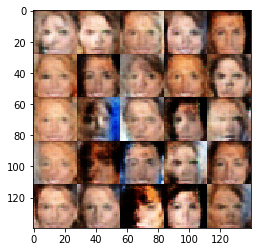

Epoch 1/1... Batch 1510... Discriminator Loss: 0.7698... Generator Loss: 1.0413
Epoch 1/1... Batch 1520... Discriminator Loss: 0.9263... Generator Loss: 1.2287
Epoch 1/1... Batch 1530... Discriminator Loss: 1.3227... Generator Loss: 1.1902
Epoch 1/1... Batch 1540... Discriminator Loss: 1.0924... Generator Loss: 0.6810
Epoch 1/1... Batch 1550... Discriminator Loss: 1.1920... Generator Loss: 0.5410
Epoch 1/1... Batch 1560... Discriminator Loss: 1.4209... Generator Loss: 2.7915
Epoch 1/1... Batch 1570... Discriminator Loss: 1.0580... Generator Loss: 0.5394
Epoch 1/1... Batch 1580... Discriminator Loss: 1.0318... Generator Loss: 0.6954
Epoch 1/1... Batch 1590... Discriminator Loss: 2.5442... Generator Loss: 0.1080
Epoch 1/1... Batch 1600... Discriminator Loss: 1.3657... Generator Loss: 2.4170


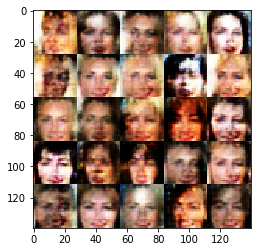

Epoch 1/1... Batch 1610... Discriminator Loss: 1.0510... Generator Loss: 0.5438
Epoch 1/1... Batch 1620... Discriminator Loss: 0.8812... Generator Loss: 0.6277
Epoch 1/1... Batch 1630... Discriminator Loss: 1.8612... Generator Loss: 0.2034
Epoch 1/1... Batch 1640... Discriminator Loss: 1.0642... Generator Loss: 0.6049
Epoch 1/1... Batch 1650... Discriminator Loss: 0.7964... Generator Loss: 1.4391
Epoch 1/1... Batch 1660... Discriminator Loss: 2.9947... Generator Loss: 3.7338
Epoch 1/1... Batch 1670... Discriminator Loss: 0.2392... Generator Loss: 1.9595
Epoch 1/1... Batch 1680... Discriminator Loss: 1.2833... Generator Loss: 0.6244
Epoch 1/1... Batch 1690... Discriminator Loss: 1.1459... Generator Loss: 0.5714
Epoch 1/1... Batch 1700... Discriminator Loss: 1.5987... Generator Loss: 2.4427


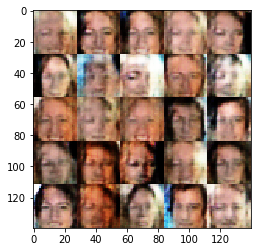

Epoch 1/1... Batch 1710... Discriminator Loss: 1.1600... Generator Loss: 0.5224
Epoch 1/1... Batch 1720... Discriminator Loss: 0.6816... Generator Loss: 1.3494
Epoch 1/1... Batch 1730... Discriminator Loss: 0.9889... Generator Loss: 0.8001
Epoch 1/1... Batch 1740... Discriminator Loss: 0.7332... Generator Loss: 1.3606
Epoch 1/1... Batch 1750... Discriminator Loss: 1.1460... Generator Loss: 0.5330
Epoch 1/1... Batch 1760... Discriminator Loss: 0.6075... Generator Loss: 1.0020
Epoch 1/1... Batch 1770... Discriminator Loss: 1.0205... Generator Loss: 0.6259
Epoch 1/1... Batch 1780... Discriminator Loss: 1.5236... Generator Loss: 0.3592
Epoch 1/1... Batch 1790... Discriminator Loss: 1.1990... Generator Loss: 0.4782
Epoch 1/1... Batch 1800... Discriminator Loss: 1.0393... Generator Loss: 0.5580


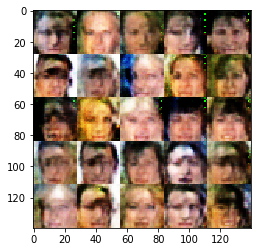

Epoch 1/1... Batch 1810... Discriminator Loss: 0.9233... Generator Loss: 0.6972
Epoch 1/1... Batch 1820... Discriminator Loss: 1.2142... Generator Loss: 2.5967
Epoch 1/1... Batch 1830... Discriminator Loss: 0.8349... Generator Loss: 1.0711
Epoch 1/1... Batch 1840... Discriminator Loss: 1.4459... Generator Loss: 2.2395
Epoch 1/1... Batch 1850... Discriminator Loss: 1.2094... Generator Loss: 0.5343
Epoch 1/1... Batch 1860... Discriminator Loss: 0.4808... Generator Loss: 1.1662
Epoch 1/1... Batch 1870... Discriminator Loss: 3.5437... Generator Loss: 3.4733
Epoch 1/1... Batch 1880... Discriminator Loss: 1.4677... Generator Loss: 0.9333
Epoch 1/1... Batch 1890... Discriminator Loss: 1.0802... Generator Loss: 0.9168
Epoch 1/1... Batch 1900... Discriminator Loss: 0.8032... Generator Loss: 0.9026


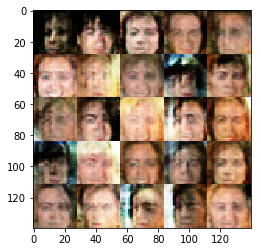

Epoch 1/1... Batch 1910... Discriminator Loss: 1.1482... Generator Loss: 1.9072
Epoch 1/1... Batch 1920... Discriminator Loss: 2.2567... Generator Loss: 3.4766
Epoch 1/1... Batch 1930... Discriminator Loss: 0.7290... Generator Loss: 1.5556
Epoch 1/1... Batch 1940... Discriminator Loss: 0.3868... Generator Loss: 1.6457
Epoch 1/1... Batch 1950... Discriminator Loss: 1.2048... Generator Loss: 0.4622
Epoch 1/1... Batch 1960... Discriminator Loss: 3.2142... Generator Loss: 3.5746
Epoch 1/1... Batch 1970... Discriminator Loss: 1.0687... Generator Loss: 0.8045
Epoch 1/1... Batch 1980... Discriminator Loss: 0.7934... Generator Loss: 0.8361
Epoch 1/1... Batch 1990... Discriminator Loss: 0.9369... Generator Loss: 0.6262
Epoch 1/1... Batch 2000... Discriminator Loss: 1.0145... Generator Loss: 0.7350


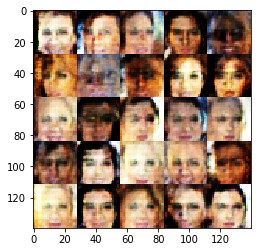

Epoch 1/1... Batch 2010... Discriminator Loss: 0.8933... Generator Loss: 0.9987
Epoch 1/1... Batch 2020... Discriminator Loss: 1.1495... Generator Loss: 0.4811
Epoch 1/1... Batch 2030... Discriminator Loss: 0.5322... Generator Loss: 1.1052
Epoch 1/1... Batch 2040... Discriminator Loss: 0.6708... Generator Loss: 2.1118
Epoch 1/1... Batch 2050... Discriminator Loss: 1.2269... Generator Loss: 0.5495
Epoch 1/1... Batch 2060... Discriminator Loss: 0.5578... Generator Loss: 1.2945
Epoch 1/1... Batch 2070... Discriminator Loss: 1.5058... Generator Loss: 0.3360
Epoch 1/1... Batch 2080... Discriminator Loss: 0.6530... Generator Loss: 1.0590
Epoch 1/1... Batch 2090... Discriminator Loss: 1.2150... Generator Loss: 0.5077
Epoch 1/1... Batch 2100... Discriminator Loss: 1.0830... Generator Loss: 2.5640


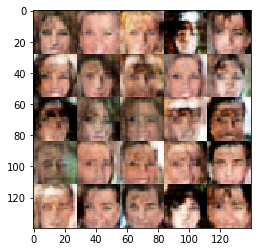

Epoch 1/1... Batch 2110... Discriminator Loss: 1.5232... Generator Loss: 0.2987
Epoch 1/1... Batch 2120... Discriminator Loss: 0.5757... Generator Loss: 1.1137
Epoch 1/1... Batch 2130... Discriminator Loss: 1.2899... Generator Loss: 0.5262
Epoch 1/1... Batch 2140... Discriminator Loss: 0.4150... Generator Loss: 1.6724
Epoch 1/1... Batch 2150... Discriminator Loss: 1.0415... Generator Loss: 1.4239
Epoch 1/1... Batch 2160... Discriminator Loss: 1.0382... Generator Loss: 0.6683
Epoch 1/1... Batch 2170... Discriminator Loss: 0.4941... Generator Loss: 1.7538
Epoch 1/1... Batch 2180... Discriminator Loss: 0.8601... Generator Loss: 0.7038
Epoch 1/1... Batch 2190... Discriminator Loss: 1.0544... Generator Loss: 1.0376
Epoch 1/1... Batch 2200... Discriminator Loss: 1.3197... Generator Loss: 0.4475


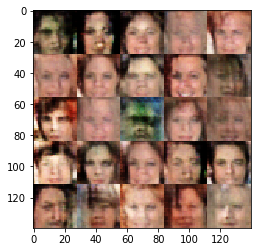

Epoch 1/1... Batch 2210... Discriminator Loss: 1.2936... Generator Loss: 0.5035
Epoch 1/1... Batch 2220... Discriminator Loss: 0.9698... Generator Loss: 0.7154
Epoch 1/1... Batch 2230... Discriminator Loss: 1.1087... Generator Loss: 0.6053
Epoch 1/1... Batch 2240... Discriminator Loss: 1.4593... Generator Loss: 0.5648
Epoch 1/1... Batch 2250... Discriminator Loss: 1.0520... Generator Loss: 0.5365
Epoch 1/1... Batch 2260... Discriminator Loss: 1.3641... Generator Loss: 0.3893
Epoch 1/1... Batch 2270... Discriminator Loss: 0.5876... Generator Loss: 1.9636
Epoch 1/1... Batch 2280... Discriminator Loss: 0.9447... Generator Loss: 0.7345
Epoch 1/1... Batch 2290... Discriminator Loss: 1.6494... Generator Loss: 2.3369
Epoch 1/1... Batch 2300... Discriminator Loss: 1.4828... Generator Loss: 0.3884


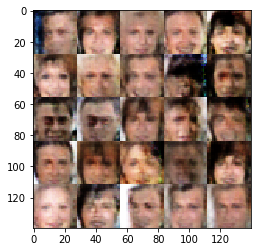

Epoch 1/1... Batch 2310... Discriminator Loss: 1.0586... Generator Loss: 0.8973
Epoch 1/1... Batch 2320... Discriminator Loss: 0.5018... Generator Loss: 1.7938
Epoch 1/1... Batch 2330... Discriminator Loss: 1.0633... Generator Loss: 0.6903
Epoch 1/1... Batch 2340... Discriminator Loss: 1.0563... Generator Loss: 0.6193
Epoch 1/1... Batch 2350... Discriminator Loss: 1.2048... Generator Loss: 0.6543
Epoch 1/1... Batch 2360... Discriminator Loss: 1.2792... Generator Loss: 0.4988
Epoch 1/1... Batch 2370... Discriminator Loss: 0.8906... Generator Loss: 1.5482
Epoch 1/1... Batch 2380... Discriminator Loss: 1.5690... Generator Loss: 0.3191
Epoch 1/1... Batch 2390... Discriminator Loss: 1.0544... Generator Loss: 0.5842
Epoch 1/1... Batch 2400... Discriminator Loss: 1.4158... Generator Loss: 1.0860


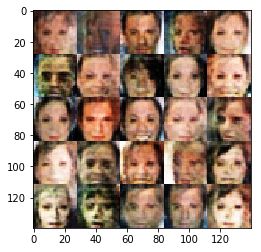

Epoch 1/1... Batch 2410... Discriminator Loss: 1.8587... Generator Loss: 2.8478
Epoch 1/1... Batch 2420... Discriminator Loss: 1.2020... Generator Loss: 0.5980
Epoch 1/1... Batch 2430... Discriminator Loss: 1.0522... Generator Loss: 0.5586
Epoch 1/1... Batch 2440... Discriminator Loss: 0.7915... Generator Loss: 0.9804
Epoch 1/1... Batch 2450... Discriminator Loss: 0.7220... Generator Loss: 1.0344
Epoch 1/1... Batch 2460... Discriminator Loss: 0.8025... Generator Loss: 1.0285
Epoch 1/1... Batch 2470... Discriminator Loss: 1.3331... Generator Loss: 0.4332
Epoch 1/1... Batch 2480... Discriminator Loss: 1.2555... Generator Loss: 0.4931
Epoch 1/1... Batch 2490... Discriminator Loss: 1.2439... Generator Loss: 0.4884
Epoch 1/1... Batch 2500... Discriminator Loss: 0.7209... Generator Loss: 1.2423


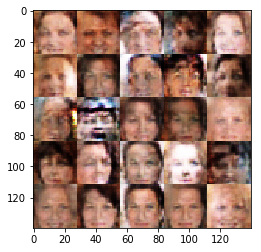

Epoch 1/1... Batch 2510... Discriminator Loss: 0.8907... Generator Loss: 3.0200
Epoch 1/1... Batch 2520... Discriminator Loss: 1.5855... Generator Loss: 2.1168
Epoch 1/1... Batch 2530... Discriminator Loss: 0.9139... Generator Loss: 0.6935
Epoch 1/1... Batch 2540... Discriminator Loss: 1.9120... Generator Loss: 0.2105
Epoch 1/1... Batch 2550... Discriminator Loss: 0.9909... Generator Loss: 0.8946
Epoch 1/1... Batch 2560... Discriminator Loss: 1.3769... Generator Loss: 0.4903
Epoch 1/1... Batch 2570... Discriminator Loss: 0.9282... Generator Loss: 0.9370
Epoch 1/1... Batch 2580... Discriminator Loss: 1.3691... Generator Loss: 0.4493
Epoch 1/1... Batch 2590... Discriminator Loss: 1.0195... Generator Loss: 0.6722
Epoch 1/1... Batch 2600... Discriminator Loss: 1.7905... Generator Loss: 0.2197


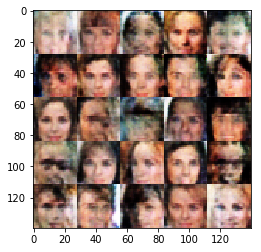

Epoch 1/1... Batch 2610... Discriminator Loss: 0.9492... Generator Loss: 0.7294
Epoch 1/1... Batch 2620... Discriminator Loss: 2.1530... Generator Loss: 0.1545
Epoch 1/1... Batch 2630... Discriminator Loss: 1.1484... Generator Loss: 0.6489
Epoch 1/1... Batch 2640... Discriminator Loss: 0.9391... Generator Loss: 1.1750
Epoch 1/1... Batch 2650... Discriminator Loss: 1.0477... Generator Loss: 1.3883
Epoch 1/1... Batch 2660... Discriminator Loss: 1.1843... Generator Loss: 0.6241
Epoch 1/1... Batch 2670... Discriminator Loss: 0.9802... Generator Loss: 1.0954
Epoch 1/1... Batch 2680... Discriminator Loss: 1.0563... Generator Loss: 1.5316
Epoch 1/1... Batch 2690... Discriminator Loss: 1.0323... Generator Loss: 0.6594
Epoch 1/1... Batch 2700... Discriminator Loss: 1.4853... Generator Loss: 0.3900


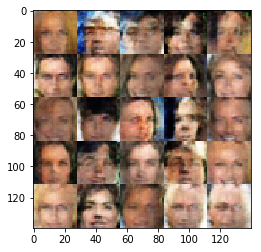

Epoch 1/1... Batch 2710... Discriminator Loss: 0.9239... Generator Loss: 0.9287
Epoch 1/1... Batch 2720... Discriminator Loss: 0.7711... Generator Loss: 1.2576
Epoch 1/1... Batch 2730... Discriminator Loss: 1.5057... Generator Loss: 2.3133
Epoch 1/1... Batch 2740... Discriminator Loss: 1.0755... Generator Loss: 0.9017
Epoch 1/1... Batch 2750... Discriminator Loss: 1.2618... Generator Loss: 0.4929
Epoch 1/1... Batch 2760... Discriminator Loss: 0.8898... Generator Loss: 1.4706
Epoch 1/1... Batch 2770... Discriminator Loss: 1.2154... Generator Loss: 1.1832
Epoch 1/1... Batch 2780... Discriminator Loss: 1.3520... Generator Loss: 0.4011
Epoch 1/1... Batch 2790... Discriminator Loss: 1.0944... Generator Loss: 1.5539
Epoch 1/1... Batch 2800... Discriminator Loss: 1.1447... Generator Loss: 1.9498


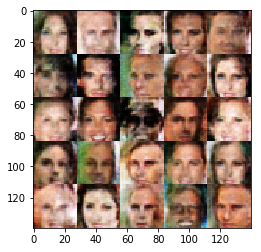

Epoch 1/1... Batch 2810... Discriminator Loss: 1.0410... Generator Loss: 0.6152
Epoch 1/1... Batch 2820... Discriminator Loss: 1.5845... Generator Loss: 0.2949
Epoch 1/1... Batch 2830... Discriminator Loss: 1.2709... Generator Loss: 0.5466
Epoch 1/1... Batch 2840... Discriminator Loss: 0.7776... Generator Loss: 0.8833
Epoch 1/1... Batch 2850... Discriminator Loss: 1.0861... Generator Loss: 0.5508
Epoch 1/1... Batch 2860... Discriminator Loss: 0.8331... Generator Loss: 1.1057
Epoch 1/1... Batch 2870... Discriminator Loss: 1.0601... Generator Loss: 0.8487
Epoch 1/1... Batch 2880... Discriminator Loss: 1.2935... Generator Loss: 0.4501
Epoch 1/1... Batch 2890... Discriminator Loss: 1.8248... Generator Loss: 0.2133
Epoch 1/1... Batch 2900... Discriminator Loss: 0.8012... Generator Loss: 1.4950


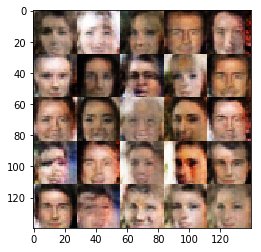

Epoch 1/1... Batch 2910... Discriminator Loss: 0.9224... Generator Loss: 1.2190
Epoch 1/1... Batch 2920... Discriminator Loss: 0.8911... Generator Loss: 1.2331
Epoch 1/1... Batch 2930... Discriminator Loss: 0.7542... Generator Loss: 1.3194
Epoch 1/1... Batch 2940... Discriminator Loss: 1.2216... Generator Loss: 1.5854
Epoch 1/1... Batch 2950... Discriminator Loss: 0.7181... Generator Loss: 2.0111
Epoch 1/1... Batch 2960... Discriminator Loss: 0.9337... Generator Loss: 0.8338
Epoch 1/1... Batch 2970... Discriminator Loss: 0.8891... Generator Loss: 1.0339
Epoch 1/1... Batch 2980... Discriminator Loss: 1.0012... Generator Loss: 0.9083
Epoch 1/1... Batch 2990... Discriminator Loss: 1.2307... Generator Loss: 1.5626
Epoch 1/1... Batch 3000... Discriminator Loss: 1.2534... Generator Loss: 0.5173


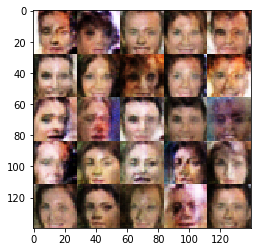

Epoch 1/1... Batch 3010... Discriminator Loss: 1.2457... Generator Loss: 0.5156
Epoch 1/1... Batch 3020... Discriminator Loss: 1.2606... Generator Loss: 0.4887
Epoch 1/1... Batch 3030... Discriminator Loss: 0.9496... Generator Loss: 0.7738
Epoch 1/1... Batch 3040... Discriminator Loss: 1.3123... Generator Loss: 0.4568
Epoch 1/1... Batch 3050... Discriminator Loss: 1.1028... Generator Loss: 0.6259
Epoch 1/1... Batch 3060... Discriminator Loss: 0.9493... Generator Loss: 1.2373
Epoch 1/1... Batch 3070... Discriminator Loss: 1.0470... Generator Loss: 0.6713
Epoch 1/1... Batch 3080... Discriminator Loss: 1.0982... Generator Loss: 0.6139
Epoch 1/1... Batch 3090... Discriminator Loss: 1.3651... Generator Loss: 0.4086
Epoch 1/1... Batch 3100... Discriminator Loss: 1.2969... Generator Loss: 0.5653


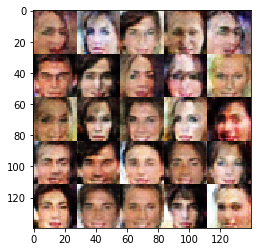

Epoch 1/1... Batch 3110... Discriminator Loss: 1.1462... Generator Loss: 1.1812
Epoch 1/1... Batch 3120... Discriminator Loss: 1.1070... Generator Loss: 0.5812
Epoch 1/1... Batch 3130... Discriminator Loss: 2.0957... Generator Loss: 0.1687
Epoch 1/1... Batch 3140... Discriminator Loss: 0.8028... Generator Loss: 1.1396
Epoch 1/1... Batch 3150... Discriminator Loss: 1.1271... Generator Loss: 1.6916
Epoch 1/1... Batch 3160... Discriminator Loss: 0.7242... Generator Loss: 1.0996
Epoch 1/1... Batch 3170... Discriminator Loss: 1.0848... Generator Loss: 0.6563
Epoch 1/1... Batch 3180... Discriminator Loss: 1.6914... Generator Loss: 0.2671
Epoch 1/1... Batch 3190... Discriminator Loss: 1.1031... Generator Loss: 2.3069
Epoch 1/1... Batch 3200... Discriminator Loss: 1.1707... Generator Loss: 0.5325


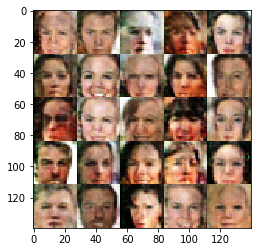

Epoch 1/1... Batch 3210... Discriminator Loss: 0.7828... Generator Loss: 0.9227
Epoch 1/1... Batch 3220... Discriminator Loss: 0.8246... Generator Loss: 1.6441
Epoch 1/1... Batch 3230... Discriminator Loss: 1.7890... Generator Loss: 0.2343
Epoch 1/1... Batch 3240... Discriminator Loss: 1.0497... Generator Loss: 1.3106
Epoch 1/1... Batch 3250... Discriminator Loss: 0.9980... Generator Loss: 0.6437
Epoch 1/1... Batch 3260... Discriminator Loss: 1.2358... Generator Loss: 0.4983
Epoch 1/1... Batch 3270... Discriminator Loss: 2.1128... Generator Loss: 0.1614
Epoch 1/1... Batch 3280... Discriminator Loss: 0.7711... Generator Loss: 0.9242
Epoch 1/1... Batch 3290... Discriminator Loss: 1.3544... Generator Loss: 0.4601
Epoch 1/1... Batch 3300... Discriminator Loss: 1.1145... Generator Loss: 0.6863


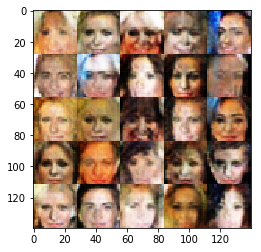

Epoch 1/1... Batch 3310... Discriminator Loss: 1.2585... Generator Loss: 0.4465
Epoch 1/1... Batch 3320... Discriminator Loss: 1.0684... Generator Loss: 0.6857
Epoch 1/1... Batch 3330... Discriminator Loss: 1.1962... Generator Loss: 0.5591
Epoch 1/1... Batch 3340... Discriminator Loss: 1.2627... Generator Loss: 0.4712
Epoch 1/1... Batch 3350... Discriminator Loss: 0.7818... Generator Loss: 1.4094
Epoch 1/1... Batch 3360... Discriminator Loss: 1.2685... Generator Loss: 0.4672
Epoch 1/1... Batch 3370... Discriminator Loss: 1.6564... Generator Loss: 0.2673
Epoch 1/1... Batch 3380... Discriminator Loss: 0.8157... Generator Loss: 1.0062
Epoch 1/1... Batch 3390... Discriminator Loss: 1.4399... Generator Loss: 0.3280
Epoch 1/1... Batch 3400... Discriminator Loss: 1.3064... Generator Loss: 0.4885


Epoch 1/1... Batch 3410... Discriminator Loss: 1.3876... Generator Loss: 0.4259
Epoch 1/1... Batch 3420... Discriminator Loss: 1.1786... Generator Loss: 1.2153
Epoch 1/1... Batch 3430... Discriminator Loss: 1.2840... Generator Loss: 0.4958
Epoch 1/1... Batch 3440... Discriminator Loss: 1.6479... Generator Loss: 0.2931
Epoch 1/1... Batch 3450... Discriminator Loss: 1.5319... Generator Loss: 0.3284
Epoch 1/1... Batch 3460... Discriminator Loss: 1.3410... Generator Loss: 0.5274
Epoch 1/1... Batch 3470... Discriminator Loss: 0.9172... Generator Loss: 0.9958
Epoch 1/1... Batch 3480... Discriminator Loss: 1.6425... Generator Loss: 0.3122
Epoch 1/1... Batch 3490... Discriminator Loss: 0.7555... Generator Loss: 0.8202
Epoch 1/1... Batch 3500... Discriminator Loss: 1.1090... Generator Loss: 0.7478


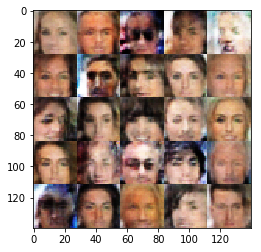

Epoch 1/1... Batch 3510... Discriminator Loss: 0.9090... Generator Loss: 0.9683
Epoch 1/1... Batch 3520... Discriminator Loss: 1.0192... Generator Loss: 0.7120
Epoch 1/1... Batch 3530... Discriminator Loss: 0.7736... Generator Loss: 1.8596
Epoch 1/1... Batch 3540... Discriminator Loss: 1.5739... Generator Loss: 0.3557
Epoch 1/1... Batch 3550... Discriminator Loss: 1.4705... Generator Loss: 0.3394
Epoch 1/1... Batch 3560... Discriminator Loss: 0.7294... Generator Loss: 1.2912
Epoch 1/1... Batch 3570... Discriminator Loss: 1.0105... Generator Loss: 1.4258
Epoch 1/1... Batch 3580... Discriminator Loss: 0.9061... Generator Loss: 0.6833
Epoch 1/1... Batch 3590... Discriminator Loss: 1.2766... Generator Loss: 0.4516
Epoch 1/1... Batch 3600... Discriminator Loss: 1.0248... Generator Loss: 0.6638


Epoch 1/1... Batch 3610... Discriminator Loss: 1.3692... Generator Loss: 2.0765
Epoch 1/1... Batch 3620... Discriminator Loss: 1.7015... Generator Loss: 0.2523
Epoch 1/1... Batch 3630... Discriminator Loss: 1.1110... Generator Loss: 0.6721
Epoch 1/1... Batch 3640... Discriminator Loss: 1.8591... Generator Loss: 0.2006
Epoch 1/1... Batch 3650... Discriminator Loss: 1.0221... Generator Loss: 1.1466
Epoch 1/1... Batch 3660... Discriminator Loss: 1.0518... Generator Loss: 0.7218
Epoch 1/1... Batch 3670... Discriminator Loss: 1.9077... Generator Loss: 0.2170
Epoch 1/1... Batch 3680... Discriminator Loss: 1.1452... Generator Loss: 0.8348
Epoch 1/1... Batch 3690... Discriminator Loss: 1.1453... Generator Loss: 1.0642
Epoch 1/1... Batch 3700... Discriminator Loss: 0.5665... Generator Loss: 1.1817


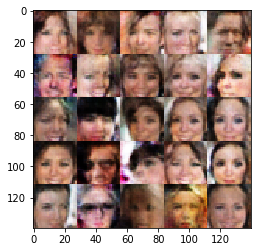

Epoch 1/1... Batch 3710... Discriminator Loss: 1.0168... Generator Loss: 1.0837
Epoch 1/1... Batch 3720... Discriminator Loss: 1.2735... Generator Loss: 0.5147
Epoch 1/1... Batch 3730... Discriminator Loss: 0.9053... Generator Loss: 0.7098
Epoch 1/1... Batch 3740... Discriminator Loss: 1.0740... Generator Loss: 1.3646
Epoch 1/1... Batch 3750... Discriminator Loss: 1.1026... Generator Loss: 0.6204
Epoch 1/1... Batch 3760... Discriminator Loss: 0.8476... Generator Loss: 0.9565
Epoch 1/1... Batch 3770... Discriminator Loss: 0.7079... Generator Loss: 1.0917
Epoch 1/1... Batch 3780... Discriminator Loss: 1.1089... Generator Loss: 0.8311
Epoch 1/1... Batch 3790... Discriminator Loss: 1.1276... Generator Loss: 0.6187
Epoch 1/1... Batch 3800... Discriminator Loss: 0.8278... Generator Loss: 1.1006


Epoch 1/1... Batch 3810... Discriminator Loss: 1.2204... Generator Loss: 1.5117
Epoch 1/1... Batch 3820... Discriminator Loss: 1.8297... Generator Loss: 0.2428
Epoch 1/1... Batch 3830... Discriminator Loss: 1.8466... Generator Loss: 0.2232
Epoch 1/1... Batch 3840... Discriminator Loss: 0.9766... Generator Loss: 0.7695
Epoch 1/1... Batch 3850... Discriminator Loss: 0.9581... Generator Loss: 0.8654
Epoch 1/1... Batch 3860... Discriminator Loss: 0.9641... Generator Loss: 1.0859
Epoch 1/1... Batch 3870... Discriminator Loss: 1.0090... Generator Loss: 0.8893
Epoch 1/1... Batch 3880... Discriminator Loss: 0.9134... Generator Loss: 1.1604
Epoch 1/1... Batch 3890... Discriminator Loss: 1.1413... Generator Loss: 1.3825
Epoch 1/1... Batch 3900... Discriminator Loss: 0.9577... Generator Loss: 0.7522


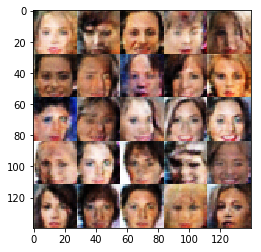

Epoch 1/1... Batch 3910... Discriminator Loss: 1.1543... Generator Loss: 0.8200
Epoch 1/1... Batch 3920... Discriminator Loss: 1.8173... Generator Loss: 0.2090
Epoch 1/1... Batch 3930... Discriminator Loss: 1.2355... Generator Loss: 0.5371
Epoch 1/1... Batch 3940... Discriminator Loss: 1.5154... Generator Loss: 0.3340
Epoch 1/1... Batch 3950... Discriminator Loss: 1.3757... Generator Loss: 0.3734
Epoch 1/1... Batch 3960... Discriminator Loss: 0.7975... Generator Loss: 1.3243
Epoch 1/1... Batch 3970... Discriminator Loss: 1.1551... Generator Loss: 0.6680
Epoch 1/1... Batch 3980... Discriminator Loss: 1.0013... Generator Loss: 1.4657
Epoch 1/1... Batch 3990... Discriminator Loss: 1.7281... Generator Loss: 0.2386
Epoch 1/1... Batch 4000... Discriminator Loss: 1.1923... Generator Loss: 1.6886


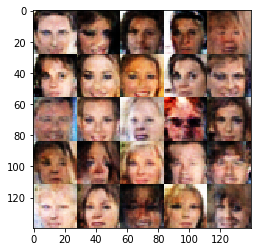

Epoch 1/1... Batch 4010... Discriminator Loss: 1.2045... Generator Loss: 0.5207
Epoch 1/1... Batch 4020... Discriminator Loss: 0.8795... Generator Loss: 0.8868
Epoch 1/1... Batch 4030... Discriminator Loss: 1.0256... Generator Loss: 1.0007
Epoch 1/1... Batch 4040... Discriminator Loss: 0.8176... Generator Loss: 1.9846
Epoch 1/1... Batch 4050... Discriminator Loss: 0.9641... Generator Loss: 1.4849
Epoch 1/1... Batch 4060... Discriminator Loss: 1.0078... Generator Loss: 0.6502
Epoch 1/1... Batch 4070... Discriminator Loss: 1.1221... Generator Loss: 0.5501
Epoch 1/1... Batch 4080... Discriminator Loss: 1.7543... Generator Loss: 0.2732
Epoch 1/1... Batch 4090... Discriminator Loss: 1.2340... Generator Loss: 1.1560
Epoch 1/1... Batch 4100... Discriminator Loss: 1.2985... Generator Loss: 0.4379


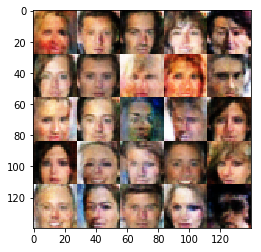

Epoch 1/1... Batch 4110... Discriminator Loss: 0.9844... Generator Loss: 0.6540
Epoch 1/1... Batch 4120... Discriminator Loss: 1.3794... Generator Loss: 0.3628
Epoch 1/1... Batch 4130... Discriminator Loss: 1.2992... Generator Loss: 0.5032
Epoch 1/1... Batch 4140... Discriminator Loss: 1.2842... Generator Loss: 0.5011
Epoch 1/1... Batch 4150... Discriminator Loss: 1.1935... Generator Loss: 0.5303
Epoch 1/1... Batch 4160... Discriminator Loss: 1.2604... Generator Loss: 0.4550
Epoch 1/1... Batch 4170... Discriminator Loss: 1.2825... Generator Loss: 0.5038
Epoch 1/1... Batch 4180... Discriminator Loss: 0.8606... Generator Loss: 1.1268
Epoch 1/1... Batch 4190... Discriminator Loss: 1.1154... Generator Loss: 0.5693
Epoch 1/1... Batch 4200... Discriminator Loss: 1.3242... Generator Loss: 0.4222


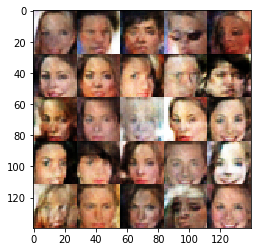

Epoch 1/1... Batch 4210... Discriminator Loss: 1.5088... Generator Loss: 0.3385
Epoch 1/1... Batch 4220... Discriminator Loss: 1.0878... Generator Loss: 0.8438
Epoch 1/1... Batch 4230... Discriminator Loss: 1.5227... Generator Loss: 0.3511
Epoch 1/1... Batch 4240... Discriminator Loss: 1.0608... Generator Loss: 0.7081
Epoch 1/1... Batch 4250... Discriminator Loss: 1.0345... Generator Loss: 1.1827
Epoch 1/1... Batch 4260... Discriminator Loss: 1.3205... Generator Loss: 0.4414
Epoch 1/1... Batch 4270... Discriminator Loss: 1.0693... Generator Loss: 0.6290
Epoch 1/1... Batch 4280... Discriminator Loss: 1.0440... Generator Loss: 0.6714
Epoch 1/1... Batch 4290... Discriminator Loss: 1.1415... Generator Loss: 0.6980
Epoch 1/1... Batch 4300... Discriminator Loss: 1.8711... Generator Loss: 0.2209


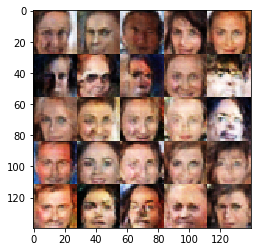

Epoch 1/1... Batch 4310... Discriminator Loss: 0.9905... Generator Loss: 0.7078
Epoch 1/1... Batch 4320... Discriminator Loss: 1.0381... Generator Loss: 0.6287
Epoch 1/1... Batch 4330... Discriminator Loss: 1.4004... Generator Loss: 0.3829
Epoch 1/1... Batch 4340... Discriminator Loss: 0.8884... Generator Loss: 0.8146
Epoch 1/1... Batch 4350... Discriminator Loss: 0.6744... Generator Loss: 1.1826
Epoch 1/1... Batch 4360... Discriminator Loss: 0.9271... Generator Loss: 0.9107
Epoch 1/1... Batch 4370... Discriminator Loss: 1.1174... Generator Loss: 0.4957
Epoch 1/1... Batch 4380... Discriminator Loss: 1.0400... Generator Loss: 0.6694
Epoch 1/1... Batch 4390... Discriminator Loss: 1.7153... Generator Loss: 0.2518
Epoch 1/1... Batch 4400... Discriminator Loss: 1.0925... Generator Loss: 0.5342


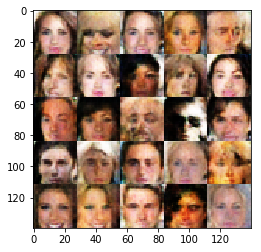

Epoch 1/1... Batch 4410... Discriminator Loss: 1.6516... Generator Loss: 2.7323
Epoch 1/1... Batch 4420... Discriminator Loss: 1.1282... Generator Loss: 1.6086
Epoch 1/1... Batch 4430... Discriminator Loss: 1.4309... Generator Loss: 0.4265
Epoch 1/1... Batch 4440... Discriminator Loss: 0.9899... Generator Loss: 1.1048
Epoch 1/1... Batch 4450... Discriminator Loss: 0.8643... Generator Loss: 0.9950
Epoch 1/1... Batch 4460... Discriminator Loss: 1.2044... Generator Loss: 0.4601
Epoch 1/1... Batch 4470... Discriminator Loss: 0.6844... Generator Loss: 1.0075
Epoch 1/1... Batch 4480... Discriminator Loss: 1.6272... Generator Loss: 0.2613
Epoch 1/1... Batch 4490... Discriminator Loss: 1.0612... Generator Loss: 0.7833
Epoch 1/1... Batch 4500... Discriminator Loss: 0.7981... Generator Loss: 1.3454


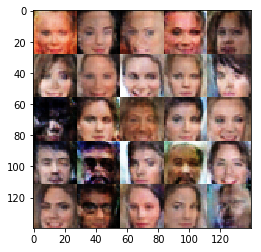

Epoch 1/1... Batch 4510... Discriminator Loss: 2.2249... Generator Loss: 0.1561
Epoch 1/1... Batch 4520... Discriminator Loss: 1.5023... Generator Loss: 0.3326
Epoch 1/1... Batch 4530... Discriminator Loss: 1.1837... Generator Loss: 0.6129
Epoch 1/1... Batch 4540... Discriminator Loss: 0.8905... Generator Loss: 0.9988
Epoch 1/1... Batch 4550... Discriminator Loss: 0.9662... Generator Loss: 0.6932
Epoch 1/1... Batch 4560... Discriminator Loss: 0.9939... Generator Loss: 0.7778
Epoch 1/1... Batch 4570... Discriminator Loss: 1.0556... Generator Loss: 0.7910
Epoch 1/1... Batch 4580... Discriminator Loss: 1.4460... Generator Loss: 0.3603
Epoch 1/1... Batch 4590... Discriminator Loss: 1.5416... Generator Loss: 0.3938
Epoch 1/1... Batch 4600... Discriminator Loss: 1.3919... Generator Loss: 0.3855


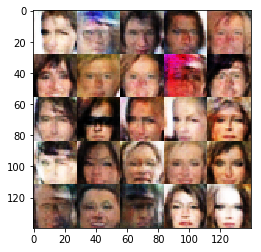

Epoch 1/1... Batch 4610... Discriminator Loss: 1.3544... Generator Loss: 0.4094
Epoch 1/1... Batch 4620... Discriminator Loss: 1.0566... Generator Loss: 0.6603
Epoch 1/1... Batch 4630... Discriminator Loss: 1.1024... Generator Loss: 0.7013
Epoch 1/1... Batch 4640... Discriminator Loss: 0.9201... Generator Loss: 0.9651
Epoch 1/1... Batch 4650... Discriminator Loss: 1.1080... Generator Loss: 1.5852
Epoch 1/1... Batch 4660... Discriminator Loss: 1.1487... Generator Loss: 0.7588
Epoch 1/1... Batch 4670... Discriminator Loss: 1.5073... Generator Loss: 0.3107
Epoch 1/1... Batch 4680... Discriminator Loss: 0.8053... Generator Loss: 1.0846
Epoch 1/1... Batch 4690... Discriminator Loss: 1.2696... Generator Loss: 1.9764
Epoch 1/1... Batch 4700... Discriminator Loss: 1.3783... Generator Loss: 1.7395


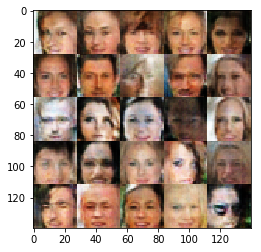

Epoch 1/1... Batch 4710... Discriminator Loss: 1.3345... Generator Loss: 0.4088
Epoch 1/1... Batch 4720... Discriminator Loss: 1.3098... Generator Loss: 0.4777
Epoch 1/1... Batch 4730... Discriminator Loss: 1.3592... Generator Loss: 0.4231
Epoch 1/1... Batch 4740... Discriminator Loss: 0.9657... Generator Loss: 1.4444
Epoch 1/1... Batch 4750... Discriminator Loss: 1.0934... Generator Loss: 0.6401
Epoch 1/1... Batch 4760... Discriminator Loss: 0.8694... Generator Loss: 1.2633
Epoch 1/1... Batch 4770... Discriminator Loss: 1.1918... Generator Loss: 1.4233
Epoch 1/1... Batch 4780... Discriminator Loss: 1.1101... Generator Loss: 0.7939
Epoch 1/1... Batch 4790... Discriminator Loss: 1.0528... Generator Loss: 0.7380
Epoch 1/1... Batch 4800... Discriminator Loss: 1.9435... Generator Loss: 0.2135


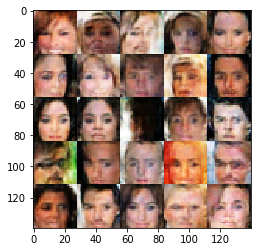

Epoch 1/1... Batch 4810... Discriminator Loss: 2.0362... Generator Loss: 0.1982
Epoch 1/1... Batch 4820... Discriminator Loss: 1.1602... Generator Loss: 1.8953
Epoch 1/1... Batch 4830... Discriminator Loss: 1.0177... Generator Loss: 1.3889
Epoch 1/1... Batch 4840... Discriminator Loss: 1.7150... Generator Loss: 0.2855
Epoch 1/1... Batch 4850... Discriminator Loss: 1.3387... Generator Loss: 0.4748
Epoch 1/1... Batch 4860... Discriminator Loss: 1.3923... Generator Loss: 0.3561
Epoch 1/1... Batch 4870... Discriminator Loss: 1.2307... Generator Loss: 0.5224
Epoch 1/1... Batch 4880... Discriminator Loss: 1.1572... Generator Loss: 0.5945
Epoch 1/1... Batch 4890... Discriminator Loss: 1.1421... Generator Loss: 0.6762
Epoch 1/1... Batch 4900... Discriminator Loss: 1.0725... Generator Loss: 1.1324


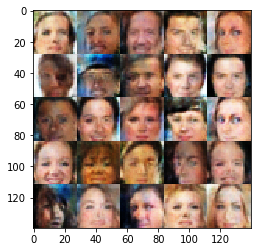

Epoch 1/1... Batch 4910... Discriminator Loss: 0.8764... Generator Loss: 0.8625
Epoch 1/1... Batch 4920... Discriminator Loss: 1.6409... Generator Loss: 0.2663
Epoch 1/1... Batch 4930... Discriminator Loss: 1.4317... Generator Loss: 0.3601
Epoch 1/1... Batch 4940... Discriminator Loss: 1.1896... Generator Loss: 2.1376
Epoch 1/1... Batch 4950... Discriminator Loss: 0.8918... Generator Loss: 1.0626
Epoch 1/1... Batch 4960... Discriminator Loss: 1.0574... Generator Loss: 0.7675
Epoch 1/1... Batch 4970... Discriminator Loss: 1.0058... Generator Loss: 0.8364
Epoch 1/1... Batch 4980... Discriminator Loss: 1.1829... Generator Loss: 0.4707
Epoch 1/1... Batch 4990... Discriminator Loss: 0.8559... Generator Loss: 1.4139
Epoch 1/1... Batch 5000... Discriminator Loss: 1.6841... Generator Loss: 2.5687


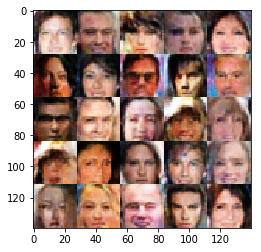

Epoch 1/1... Batch 5010... Discriminator Loss: 0.8969... Generator Loss: 1.3903
Epoch 1/1... Batch 5020... Discriminator Loss: 0.9206... Generator Loss: 0.9935
Epoch 1/1... Batch 5030... Discriminator Loss: 0.9589... Generator Loss: 1.4727
Epoch 1/1... Batch 5040... Discriminator Loss: 2.6126... Generator Loss: 0.0981
Epoch 1/1... Batch 5050... Discriminator Loss: 1.3745... Generator Loss: 0.4129
Epoch 1/1... Batch 5060... Discriminator Loss: 1.4853... Generator Loss: 0.3388
Epoch 1/1... Batch 5070... Discriminator Loss: 1.6547... Generator Loss: 0.2686
Epoch 1/1... Batch 5080... Discriminator Loss: 1.5705... Generator Loss: 0.3159
Epoch 1/1... Batch 5090... Discriminator Loss: 1.6181... Generator Loss: 0.2646
Epoch 1/1... Batch 5100... Discriminator Loss: 1.0036... Generator Loss: 0.7370


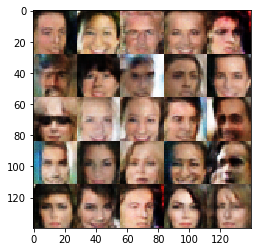

Epoch 1/1... Batch 5110... Discriminator Loss: 0.8432... Generator Loss: 0.7838
Epoch 1/1... Batch 5120... Discriminator Loss: 1.1403... Generator Loss: 0.6263
Epoch 1/1... Batch 5130... Discriminator Loss: 1.3498... Generator Loss: 0.4112
Epoch 1/1... Batch 5140... Discriminator Loss: 1.2627... Generator Loss: 0.4432
Epoch 1/1... Batch 5150... Discriminator Loss: 1.0292... Generator Loss: 0.8869
Epoch 1/1... Batch 5160... Discriminator Loss: 1.0983... Generator Loss: 0.5321
Epoch 1/1... Batch 5170... Discriminator Loss: 1.0130... Generator Loss: 0.7020
Epoch 1/1... Batch 5180... Discriminator Loss: 0.7216... Generator Loss: 1.1885
Epoch 1/1... Batch 5190... Discriminator Loss: 1.3331... Generator Loss: 0.4902
Epoch 1/1... Batch 5200... Discriminator Loss: 1.2903... Generator Loss: 0.4147


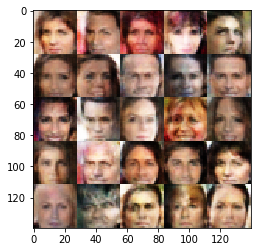

Epoch 1/1... Batch 5210... Discriminator Loss: 1.5707... Generator Loss: 0.3383
Epoch 1/1... Batch 5220... Discriminator Loss: 1.3307... Generator Loss: 0.4620
Epoch 1/1... Batch 5230... Discriminator Loss: 1.9307... Generator Loss: 0.1935
Epoch 1/1... Batch 5240... Discriminator Loss: 1.5725... Generator Loss: 0.2959
Epoch 1/1... Batch 5250... Discriminator Loss: 1.3126... Generator Loss: 0.4394
Epoch 1/1... Batch 5260... Discriminator Loss: 1.1918... Generator Loss: 0.5161
Epoch 1/1... Batch 5270... Discriminator Loss: 1.1815... Generator Loss: 0.4638
Epoch 1/1... Batch 5280... Discriminator Loss: 1.5922... Generator Loss: 1.8226
Epoch 1/1... Batch 5290... Discriminator Loss: 1.1761... Generator Loss: 0.5608
Epoch 1/1... Batch 5300... Discriminator Loss: 1.3072... Generator Loss: 0.4256


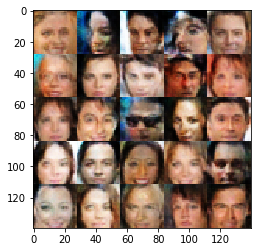

Epoch 1/1... Batch 5310... Discriminator Loss: 1.1023... Generator Loss: 1.1244
Epoch 1/1... Batch 5320... Discriminator Loss: 1.0950... Generator Loss: 0.5238
Epoch 1/1... Batch 5330... Discriminator Loss: 1.1552... Generator Loss: 0.7420
Epoch 1/1... Batch 5340... Discriminator Loss: 1.1584... Generator Loss: 0.7720
Epoch 1/1... Batch 5350... Discriminator Loss: 1.4817... Generator Loss: 0.3617
Epoch 1/1... Batch 5360... Discriminator Loss: 1.6006... Generator Loss: 0.3365
Epoch 1/1... Batch 5370... Discriminator Loss: 0.9863... Generator Loss: 0.6768
Epoch 1/1... Batch 5380... Discriminator Loss: 1.0556... Generator Loss: 0.6744
Epoch 1/1... Batch 5390... Discriminator Loss: 1.0538... Generator Loss: 0.9024
Epoch 1/1... Batch 5400... Discriminator Loss: 0.7530... Generator Loss: 0.9476


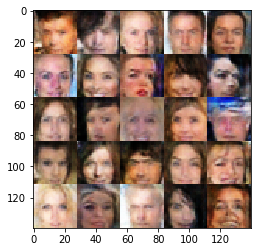

Epoch 1/1... Batch 5410... Discriminator Loss: 1.4141... Generator Loss: 0.3915
Epoch 1/1... Batch 5420... Discriminator Loss: 0.9077... Generator Loss: 1.5040
Epoch 1/1... Batch 5430... Discriminator Loss: 1.2395... Generator Loss: 0.4999
Epoch 1/1... Batch 5440... Discriminator Loss: 1.0438... Generator Loss: 0.8689
Epoch 1/1... Batch 5450... Discriminator Loss: 0.9228... Generator Loss: 0.8433
Epoch 1/1... Batch 5460... Discriminator Loss: 1.2637... Generator Loss: 0.4503
Epoch 1/1... Batch 5470... Discriminator Loss: 1.3528... Generator Loss: 0.4263
Epoch 1/1... Batch 5480... Discriminator Loss: 1.2101... Generator Loss: 1.8875
Epoch 1/1... Batch 5490... Discriminator Loss: 1.7387... Generator Loss: 0.2315
Epoch 1/1... Batch 5500... Discriminator Loss: 1.0167... Generator Loss: 0.7814


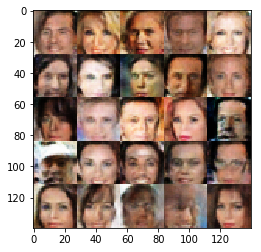

Epoch 1/1... Batch 5510... Discriminator Loss: 1.4496... Generator Loss: 0.3335
Epoch 1/1... Batch 5520... Discriminator Loss: 1.0645... Generator Loss: 0.6452
Epoch 1/1... Batch 5530... Discriminator Loss: 1.4804... Generator Loss: 0.3158
Epoch 1/1... Batch 5540... Discriminator Loss: 1.6019... Generator Loss: 0.3161
Epoch 1/1... Batch 5550... Discriminator Loss: 1.3979... Generator Loss: 0.8995
Epoch 1/1... Batch 5560... Discriminator Loss: 1.3458... Generator Loss: 0.4261
Epoch 1/1... Batch 5570... Discriminator Loss: 1.1404... Generator Loss: 1.3977
Epoch 1/1... Batch 5580... Discriminator Loss: 1.3757... Generator Loss: 0.3966
Epoch 1/1... Batch 5590... Discriminator Loss: 0.9032... Generator Loss: 0.8506
Epoch 1/1... Batch 5600... Discriminator Loss: 1.4468... Generator Loss: 0.4420


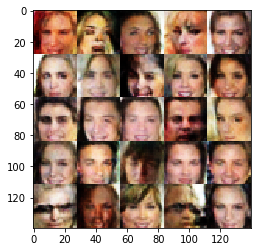

Epoch 1/1... Batch 5610... Discriminator Loss: 1.2211... Generator Loss: 0.5065
Epoch 1/1... Batch 5620... Discriminator Loss: 1.0691... Generator Loss: 0.6961
Epoch 1/1... Batch 5630... Discriminator Loss: 1.7113... Generator Loss: 0.2483
Epoch 1/1... Batch 5640... Discriminator Loss: 0.8610... Generator Loss: 1.6002
Epoch 1/1... Batch 5650... Discriminator Loss: 1.3517... Generator Loss: 0.4907
Epoch 1/1... Batch 5660... Discriminator Loss: 1.5199... Generator Loss: 0.3608
Epoch 1/1... Batch 5670... Discriminator Loss: 1.6189... Generator Loss: 0.3039
Epoch 1/1... Batch 5680... Discriminator Loss: 1.0900... Generator Loss: 0.6515
Epoch 1/1... Batch 5690... Discriminator Loss: 1.1454... Generator Loss: 0.6992
Epoch 1/1... Batch 5700... Discriminator Loss: 1.3283... Generator Loss: 0.4409


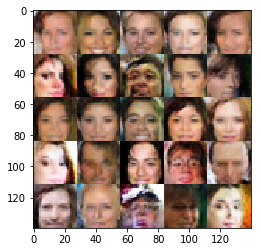

Epoch 1/1... Batch 5710... Discriminator Loss: 0.9162... Generator Loss: 0.7508
Epoch 1/1... Batch 5720... Discriminator Loss: 0.5900... Generator Loss: 1.2723
Epoch 1/1... Batch 5730... Discriminator Loss: 1.1688... Generator Loss: 0.5283
Epoch 1/1... Batch 5740... Discriminator Loss: 1.0398... Generator Loss: 0.9162
Epoch 1/1... Batch 5750... Discriminator Loss: 1.1046... Generator Loss: 0.6543
Epoch 1/1... Batch 5760... Discriminator Loss: 1.0618... Generator Loss: 1.4622
Epoch 1/1... Batch 5770... Discriminator Loss: 1.2824... Generator Loss: 0.6005
Epoch 1/1... Batch 5780... Discriminator Loss: 1.1313... Generator Loss: 0.7734
Epoch 1/1... Batch 5790... Discriminator Loss: 1.4342... Generator Loss: 0.3825
Epoch 1/1... Batch 5800... Discriminator Loss: 1.5503... Generator Loss: 0.3193


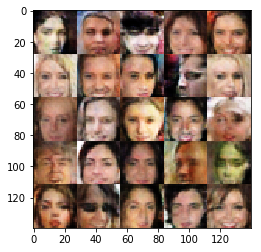

Epoch 1/1... Batch 5810... Discriminator Loss: 1.6003... Generator Loss: 0.3024
Epoch 1/1... Batch 5820... Discriminator Loss: 0.8807... Generator Loss: 0.7692
Epoch 1/1... Batch 5830... Discriminator Loss: 1.1794... Generator Loss: 1.5318
Epoch 1/1... Batch 5840... Discriminator Loss: 1.3346... Generator Loss: 0.5149
Epoch 1/1... Batch 5850... Discriminator Loss: 1.3147... Generator Loss: 2.5212
Epoch 1/1... Batch 5860... Discriminator Loss: 1.0373... Generator Loss: 1.7908
Epoch 1/1... Batch 5870... Discriminator Loss: 1.1928... Generator Loss: 1.3622
Epoch 1/1... Batch 5880... Discriminator Loss: 1.1190... Generator Loss: 0.5943
Epoch 1/1... Batch 5890... Discriminator Loss: 1.0929... Generator Loss: 1.1551
Epoch 1/1... Batch 5900... Discriminator Loss: 1.1529... Generator Loss: 0.6196


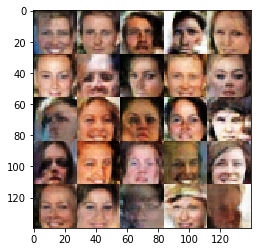

Epoch 1/1... Batch 5910... Discriminator Loss: 1.1654... Generator Loss: 0.5746
Epoch 1/1... Batch 5920... Discriminator Loss: 1.0406... Generator Loss: 1.0201
Epoch 1/1... Batch 5930... Discriminator Loss: 1.4314... Generator Loss: 0.3699
Epoch 1/1... Batch 5940... Discriminator Loss: 1.6853... Generator Loss: 0.2492
Epoch 1/1... Batch 5950... Discriminator Loss: 1.0834... Generator Loss: 0.6670
Epoch 1/1... Batch 5960... Discriminator Loss: 1.0452... Generator Loss: 0.8167
Epoch 1/1... Batch 5970... Discriminator Loss: 1.8909... Generator Loss: 0.2235
Epoch 1/1... Batch 5980... Discriminator Loss: 1.2917... Generator Loss: 0.4220
Epoch 1/1... Batch 5990... Discriminator Loss: 0.9719... Generator Loss: 0.7467
Epoch 1/1... Batch 6000... Discriminator Loss: 0.6638... Generator Loss: 0.9620


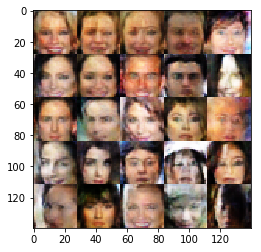

Epoch 1/1... Batch 6010... Discriminator Loss: 1.8564... Generator Loss: 0.2241
Epoch 1/1... Batch 6020... Discriminator Loss: 1.4622... Generator Loss: 0.3515
Epoch 1/1... Batch 6030... Discriminator Loss: 1.9438... Generator Loss: 0.1958
Epoch 1/1... Batch 6040... Discriminator Loss: 1.3034... Generator Loss: 0.4717
Epoch 1/1... Batch 6050... Discriminator Loss: 1.0968... Generator Loss: 0.5091
Epoch 1/1... Batch 6060... Discriminator Loss: 1.3775... Generator Loss: 0.4206
Epoch 1/1... Batch 6070... Discriminator Loss: 1.1471... Generator Loss: 0.6813
Epoch 1/1... Batch 6080... Discriminator Loss: 1.1789... Generator Loss: 0.5786
Epoch 1/1... Batch 6090... Discriminator Loss: 1.1443... Generator Loss: 0.5620
Epoch 1/1... Batch 6100... Discriminator Loss: 0.9241... Generator Loss: 1.0852


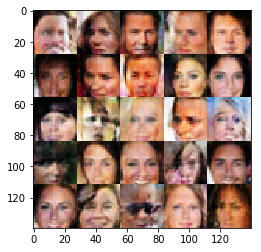

Epoch 1/1... Batch 6110... Discriminator Loss: 1.4901... Generator Loss: 0.3441
Epoch 1/1... Batch 6120... Discriminator Loss: 1.5115... Generator Loss: 0.3903
Epoch 1/1... Batch 6130... Discriminator Loss: 0.9028... Generator Loss: 1.3410
Epoch 1/1... Batch 6140... Discriminator Loss: 1.4642... Generator Loss: 1.3551
Epoch 1/1... Batch 6150... Discriminator Loss: 0.9940... Generator Loss: 0.7207
Epoch 1/1... Batch 6160... Discriminator Loss: 0.8937... Generator Loss: 0.7490
Epoch 1/1... Batch 6170... Discriminator Loss: 1.0271... Generator Loss: 0.6762
Epoch 1/1... Batch 6180... Discriminator Loss: 0.7839... Generator Loss: 1.1329
Epoch 1/1... Batch 6190... Discriminator Loss: 1.0696... Generator Loss: 0.5897
Epoch 1/1... Batch 6200... Discriminator Loss: 1.1498... Generator Loss: 0.6054


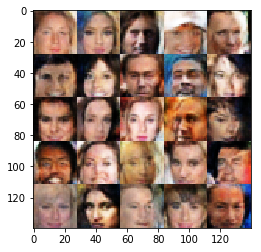

Epoch 1/1... Batch 6210... Discriminator Loss: 2.0931... Generator Loss: 0.1872
Epoch 1/1... Batch 6220... Discriminator Loss: 1.2624... Generator Loss: 0.7682
Epoch 1/1... Batch 6230... Discriminator Loss: 1.8159... Generator Loss: 0.2123
Epoch 1/1... Batch 6240... Discriminator Loss: 1.3004... Generator Loss: 0.5090
Epoch 1/1... Batch 6250... Discriminator Loss: 0.7798... Generator Loss: 1.0725
Epoch 1/1... Batch 6260... Discriminator Loss: 1.1478... Generator Loss: 0.5534
Epoch 1/1... Batch 6270... Discriminator Loss: 1.1013... Generator Loss: 0.9388
Epoch 1/1... Batch 6280... Discriminator Loss: 1.0065... Generator Loss: 0.9927
Epoch 1/1... Batch 6290... Discriminator Loss: 1.3105... Generator Loss: 0.4438
Epoch 1/1... Batch 6300... Discriminator Loss: 1.1994... Generator Loss: 0.5676


Epoch 1/1... Batch 6310... Discriminator Loss: 1.1673... Generator Loss: 0.9967
Epoch 1/1... Batch 6320... Discriminator Loss: 1.0439... Generator Loss: 0.9328
Epoch 1/1... Batch 6330... Discriminator Loss: 1.0246... Generator Loss: 0.9961


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.